In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt 
from matplotlib.patches import Rectangle
from IPython.display import Image, display
import pandas as pd

#### Functions

In [2]:
def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon,back=False):
    topo = []
    if back == False: 
        for i in range(ll, ul+1):
            for j in range(39):
                if (fmask[j, i]== 0):
                    try:
                        rect = Rectangle((u_lons[i-1]/m2lon, w_depths[j]), u_lons[i]/m2lon-u_lons[i-1]/m2lon, w_depths[j+1]-w_depths[j])
                        topo.append(rect)
                    except:
                        pass
    else:
         for i in range(ll, ul+2):
            for j in range(39):
                if (fmask[j, i]== 0):
                    try:
                        rect = Rectangle((u_lons[i-2]/m2lon, w_depths[j]), u_lons[i-1]/m2lon-u_lons[i-2]/m2lon, w_depths[j+1]-w_depths[j])
                        topo.append(rect)
                    except:
                        pass         
    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

#TODO: Rename this function (in all files)
def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel,NW=False,contours=False,Cbins=[],Cidx=0):
    
    if NW == True:
        latgridf = latgridi-1 #actually lon
        fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
        tmask = mesh.tmask[0]
        
        lons = data.init_lat[(data.final_section != 0)]
        
        f_lons = mesh.glamf[0,:, latgridf]
        u_lons = mesh.glamv[0,:, latgridf]
        w_depths = mesh.gdepw_1d
    else:
        latgridf = latgridi-1
        fmask = mesh.vmask[0, :, latgridf]
        tmask = mesh.tmask[0]
            
        lons = data.init_lon[(data.final_section != 0)]
            
        f_lons = mesh.glamf[0, latgridf]
        u_lons = mesh.glamv[0, latgridf]
        w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.dense
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec-1)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE+1:1]/m2lon),w_depths[0,0:depi+1]],
                              density=True,vmax=vmax
                                )
    X,Y = np.meshgrid(xe,ye)
    
    try:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    except:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    if NW==True:
        axv.set_xlabel('Latitude (°N)')
    else:
        axv.set_xlabel('Longitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+3]/m2lon,f_lons[lonE-3]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(abs(label)) for label in np.linspace(f_lons[lonW+3],f_lons[lonE-3],2)])
    axv.set_xticklabels(np.round(np.linspace(np.abs(f_lons[lonW+3]),np.abs(f_lons[lonE-3]),2),2))
    
    ## Add contours
    if contours == True:

        densfiles = [xr.open_dataset(f'/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_grid_T_20180101_20180131.nc'),
                xr.open_dataset(f'/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_grid_T_20180701_20180731.nc')]


        density = np.ma.array(densfiles[Cidx].sigma_theta[0, :, latgridi],
                     mask=1-tmask[:, latgridi])
    
        xs, ys = np.meshgrid(np.array(mesh.glamf[0, latgridi]), np.array(mesh.gdept_1d))

        # CS = axv.contour(xs/m2lon, ys, salinity,  [30.4, 30.6 ,30.8, 31, 31.2], colors='slategrey')
        CS = axv.contour(xs/m2lon, ys, density,Cbins, colors='deeppink',linewidths=1)
        axv.clabel(CS, inline=1, fontsize=10, fmt='%1.1f')
    
    pc = draw_patches(fmask, lonW, lonE, np.array(f_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label(f'Transport (m s$^{{-1}}$) \n')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

In [3]:
def plotCS2(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel,NW=False,cfig=False,contours=False,Cbins=[],Cidx=0):
    
    if NW == True:
        latgridf = latgridi-1 #actually lon
        fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
        tmask = mesh.tmask[0]
        
        lons = data.init_lat[(data.final_section != 0)]
        
        f_lons = mesh.gphif[0,:, latgridf]
        u_lons = mesh.gphiv[0,:, latgridf]
        w_depths = mesh.gdepw_1d
    else:
        latgridf = latgridi-1
        fmask = mesh.vmask[0, :, latgridf]
        tmask = mesh.tmask[0]
            
        lons = data.init_lon[(data.final_section != 0)]
            
        f_lons = mesh.glamf[0, latgridf]
        u_lons = mesh.glamv[0, latgridf]
        w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.dense
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec-1)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE+1:1]/m2lon),w_depths[0,0:depi+1]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    try:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    except:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(abs(label)) for label in np.linspace(f_lons[lonW],f_lons[lonE],2)])
    axv.set_xticklabels(np.round(np.linspace(np.abs(f_lons[lonW]),np.abs(f_lons[lonE]),2),2))
    labs1 = np.round(np.linspace(np.abs(f_lons[lonW]),np.abs(f_lons[lonE]),2),2)
    axv.set_xticklabels(['      '+str(labs1[0]), '         '+ str(labs1[1])])
    # axv.set_xticklabels(['W','E'])
    
    if contours == True:

        densfiles = [xr.open_dataset(f'/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_grid_T_20180101_20180131.nc'),
                xr.open_dataset(f'/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_grid_T_20180701_20180731.nc')]


        density = np.ma.array(densfiles[Cidx].sigma_theta[0, :, latgridi],
                     mask=1-tmask[:, latgridi])
    
        xs, ys = np.meshgrid(np.array(mesh.glamf[0, latgridi]), np.array(mesh.gdept_1d))

        CS = axv.contour(xs/m2lon, ys, density,Cbins, colors='deeppink')
        axv.clabel(CS, inline=1, fontsize=8, fmt='%1.1f')
    
    pc = draw_patches2(fmask, lonW, lonE, np.array(f_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)  
    
    if cblabel == True:
        if cfig == True:
            plt.colorbar()
        else:
            cb = fig.colorbar(im,ax=axv)
            cb.set_label(f'Transport (m s$^{{-1}}$)')
        
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])
      
      
latsjc = 281
lonWsjc = 261
lonEsjc = 267
  
def draw_patches2(fmask, ll, ul, u_lons, w_depths,m2lon):
    transpd = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/sjctovs3_final_transp.csv')['jun'].dropna()
    lond = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/sjctovs3_final_lon.csv')['jun'].dropna()
    zd = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/sjctovs3_final_z.csv')['jun'].dropna()

    arr,xe,ye,im = ax.hist2d(lond/m2lon,df(zd-1)[0],weights=transpd,bins=[np.array(u_lons[261:267+1:1]/m2lon),w_depths[0:38+1]],
                              density=True,vmax=0.15
                                )
    
    transp = arr.T*np.sum(transpd/23)
    
    topo = []
    for i in range(ll-ll, ul-ll):
        for j in range(39-1):
            if ((transp)[j, i] == 0) and (((fmask)[j, i] == 0)):
                try:
                    rect = Rectangle((u_lons[i+ll]/m2lon, w_depths[j]), u_lons[i+ll+1]/m2lon-u_lons[i+ll]/m2lon, w_depths[j+1]-w_depths[j])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

# def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon,back=False):
#     topo = []
#     if back == False: 
#         for i in range(ll, ul+1):
#             for j in range(39):
#                 if (fmask[j, i]== 0):
#                     try:
#                         rect = Rectangle((u_lons[i-1]/m2lon, w_depths[j]), u_lons[i]/m2lon-u_lons[i-1]/m2lon, w_depths[j+1]-w_depths[j])
#                         topo.append(rect)
#                     except:
#                         pass
#     else:
#          for i in range(ll, ul+2):
#             for j in range(39):
#                 if (fmask[j, i]== 0):
#                     try:
#                         rect = Rectangle((u_lons[i-2]/m2lon, w_depths[j]), u_lons[i-1]/m2lon-u_lons[i-2]/m2lon, w_depths[j+1]-w_depths[j])
#                         topo.append(rect)
#                     except:
#                         pass         
#     pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
#     return(pc)

### Import data

In [4]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [5]:
file1 = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/prtoadm_haro_finalsalt.csv')
file2 = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/prtoadm_haro_finaltransp.csv')


pathway = ['vstoharoF','vstorosF','vstosjcF','vstoadmF','harotovsB','sjctovsB','rostovsB','admtovsB',
           'prtoharoF','prtosjcF','prtorosF','prtogulfF','harotoprB','sjctoprB','rostoprB','gulftoprB']
variables = ['finaltransp','finallat','finallon','finalz']
dict_split = {}
for pathw in pathway:
    dict_split[pathw] = {}
    for variable in variables:
        fpath = f'/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/{pathw}_{variable}.csv'
        dict_split[pathw][variable] = pd.read_csv(fpath)


In [6]:
file1 = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/prtoadm_haro_finalsalt.csv')
file2 = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/prtoadm_haro_finaltransp.csv')


pathway = ['vstoharo','vstoros','vstosjc','vstoadm','prtoharo','prtoros','prtosjc','prtogulf','harotovs','rostovs','sjctovs','admtovs','gulftoros','harotoros','sjctoros','prtoros_RS',
           'rostoadm','rostovs_RS','rostoharo','rostosjc','rostodec','vstoharo3','vstoros3','vstosjc3','vstoadm3','harotovs3','rostovs3',
           'sjctovs3','admtovs3','rostoadm3','rostovs3_RS','rostoharo3','rostosjc3','rostodec3']
variables = ['final_salt','final_transp','init_salt','init_transp','init_temp','final_lat','final_lon','init_lat','init_lon','init_z','final_z']
dict_all = {}
for pathw in pathway:
    dict_all[pathw] = {}
    for variable in variables:
        fpath = f'/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/{pathw}_{variable}.csv'
        dict_all[pathw][variable] = pd.read_csv(fpath)


In [7]:



pathway = ['vstoharoBVS','vstorosBVS','vstosjcBVS','prtoharoBPR','prtorosBPR','prtosjcBPR',
           'admtoharoBVS','admtosjcBVS','admtorosBVS','gulftoharoBPR','gulftorosBPR','gulftosjcBPR',
           'harotorosBPR','harotorosBVS','harotosjcBPR','harotosjcBVS','sjctorosBVS','sjctorosBPR',
           'sjctoharoBVS','sjctoharoBPR','rostoharoBVS','rostoharoBPR','rostosjcBVS','rostosjcBPR',
           'dectorosBVS',
           'harotovsFVS','harotoadmFVS','harotorosFVS','harotosjcFVS',
           'rostovsFVS','rostoadmFVS','rostodecFVS','rostosjcFVS','rostoharoFVS',
           'sjctovsFVS','sjctoadmFVS','sjctoharoFVS','sjctorosFVS']
variables = ['final_transp']
dict_allTransp = {}
for pathw in pathway:
    dict_allTransp[pathw] = {}
    for variable in variables:
        fpath = f'/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/{pathw}_{variable}.csv'
        dict_allTransp[pathw][variable] = pd.read_csv(fpath)

In [8]:
# lonWharo = 215
# lonEharo = 244
# latharo = 300
# lonWros=281
# lonEros=305
# latros = 267
# latsjc = 281
# lonWsjc = 261
# lonEsjc = 267
# lonWadm = 230
# lonEadm = 262
# latadm = 218
# lonWg1 = 234
# lonEg1 = 253
# latg1 = 386
# lonWpr = 260
# lonEpr = 310
# latpr = 386

lonWadm3 = 250
lonEadm3 = 268
latadm3 = 201
lonWharo = 215
lonEharo = 243
latharo = 300
lonWros=282
lonEros=305
latros = 267
latsjc = 281
lonWsjc = 261
lonEsjc = 267
lonWadm = 230
lonEadm = 262
latadm = 218
lonWg1 = 234
lonEg1 = 253
latg1 = 386
lonWpr = 260
lonEpr = 310
latpr = 386


months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
days_month = [31,28,31,30,31,30,31,31,30,31,30,31]

idx_dec = 0
idx_jun = 6

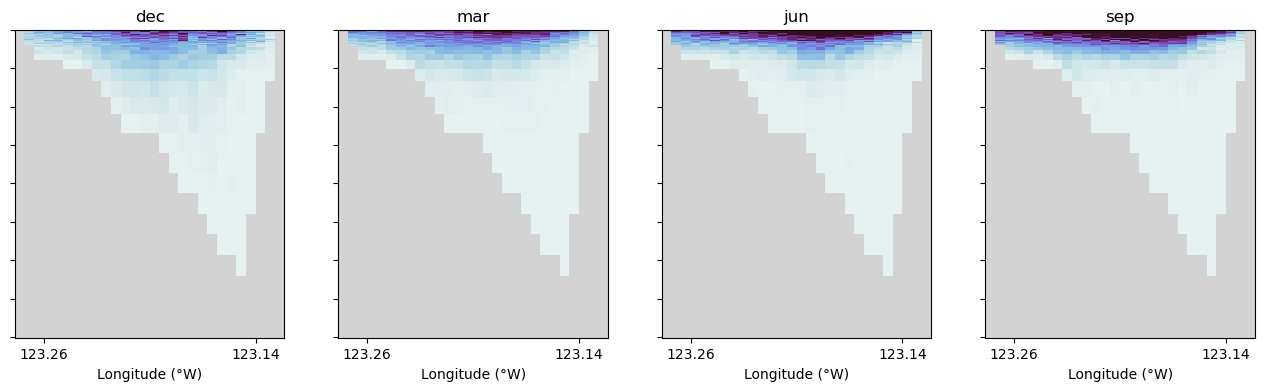

In [9]:
fig,[ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=(16,4))

for ii,ax in enumerate([ax1,ax2,ax3,ax4]):
    plotCS(ax,dict_all['prtoharo']['final_lon'][months[ii*3-1]].dropna(),dict_all['prtoharo']['final_z'][months[ii*3-1]].dropna(),dict_all['prtoharo']['final_transp'][months[ii*3-1]].dropna(),lonWharo,lonEharo,latharo,38,0.1,23*days_month[ii*3-1],months[ii*3-1],False,False)

/tmp/ipykernel_2779136/2725436767.py:44: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.2,hspace=0.25)


Text(0.5, -0.05, '(c)')

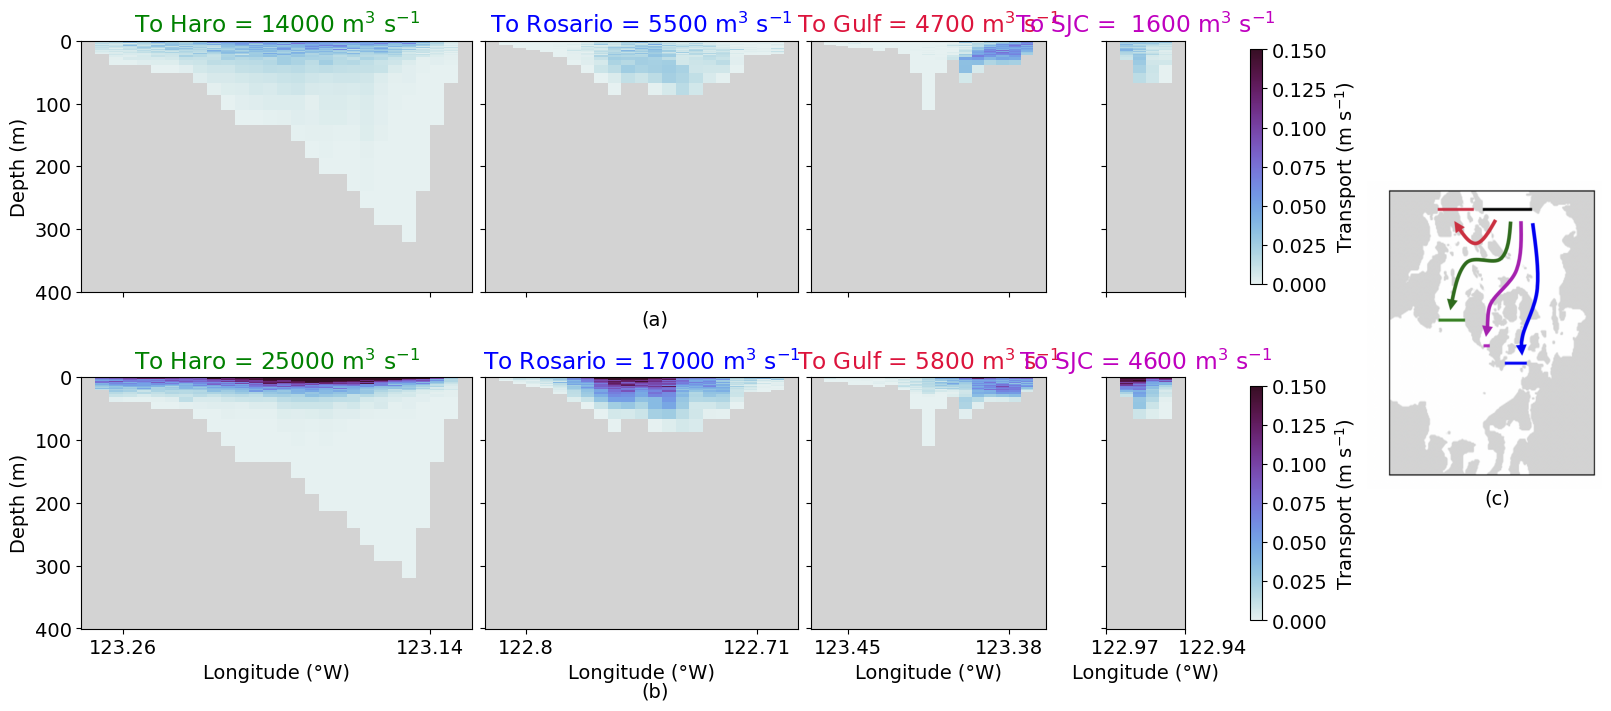

In [10]:
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 14})

title = 'To Haro = ' + str(int(np.round(np.sum(dict_all['prtoharo']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-3))) + f' m$^3$ s$^{{-1}}$'
title2 = 'To Rosario = ' + str(int(np.round(np.sum(dict_all['prtoros']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-2))) + f' m$^3$ s$^{{-1}}$'
title3 = 'To SJC =  ' + str(int(np.round(np.sum(dict_all['prtosjc']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-2))) + f' m$^3$ s$^{{-1}}$'
title4 = 'To Gulf = ' + str(int(np.round(np.sum(dict_all['prtogulf']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-2))) + f' m$^3$ s$^{{-1}}$'

title5 = 'To Haro = ' + str(int(np.round(np.sum(dict_all['prtoharo']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-3))) + f' m$^3$ s$^{{-1}}$'
title6 = 'To Rosario = ' + str(int(np.round(np.sum(dict_all['prtoros']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-3))) + f' m$^3$ s$^{{-1}}$'
title7 = 'To SJC = ' + str(int(np.round(np.sum(dict_all['prtosjc']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-2))) + f' m$^3$ s$^{{-1}}$'
title8 = 'To Gulf = ' + str(int(np.round(np.sum(dict_all['prtogulf']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-2))) + f' m$^3$ s$^{{-1}}$'

sum = 70
harolen =int(26/sum*14)
roslen = int(21/sum*14)
sjclen = int(5/sum*14)
gulflen = int(18/sum*14)
totalallen = harolen+roslen+sjclen+gulflen

fig = plt.figure(constrained_layout=True, figsize=[16,7])
gs = GridSpec(2,16, figure=fig)

ax1 = fig.add_subplot(gs[0, :harolen]) 
ax2 = fig.add_subplot(gs[0,harolen:harolen+roslen])
ax3 = fig.add_subplot(gs[0,harolen+roslen:harolen+roslen+gulflen])
ax4 = fig.add_subplot(gs[0,harolen+roslen+gulflen:harolen+roslen+gulflen+sjclen])
ax5 = fig.add_subplot(gs[1, :harolen]) 
ax6 = fig.add_subplot(gs[1,harolen:harolen+roslen])
ax7 = fig.add_subplot(gs[1,harolen+roslen:harolen+roslen+gulflen])
ax8 = fig.add_subplot(gs[1,harolen+roslen+gulflen:harolen+roslen+gulflen+sjclen])


plotCS(ax1,dict_all['prtoharo']['final_lon'][months[idx_dec]].dropna(),dict_all['prtoharo']['final_z'][months[idx_dec]].dropna(),dict_all['prtoharo']['final_transp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharo,38,0.15,23*days_month[idx_dec],title,False,True)
plotCS(ax2,dict_all['prtoros']['final_lon'][months[idx_dec]].dropna(),dict_all['prtoros']['final_z'][months[idx_dec]].dropna(),dict_all['prtoros']['final_transp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.15,23*days_month[idx_dec],title2,False,False)
plotCS2(ax4,dict_all['prtosjc']['final_lon'][months[idx_dec]].dropna(),dict_all['prtosjc']['final_z'][months[idx_dec]].dropna(),dict_all['prtosjc']['final_transp'][months[idx_dec]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.15,23*days_month[idx_dec],title3,True,False)
plotCS(ax3,dict_all['prtogulf']['final_lon'][months[idx_dec]].dropna(),dict_all['prtogulf']['final_z'][months[idx_dec]].dropna(),dict_all['prtogulf']['final_transp'][months[idx_dec]].dropna(),lonWg1,lonEg1,latg1,38,0.15,23*days_month[idx_dec],title4,False,False)

plotCS(ax5,dict_all['prtoharo']['final_lon'][months[idx_jun]].dropna(),dict_all['prtoharo']['final_z'][months[idx_jun]].dropna(),dict_all['prtoharo']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.15,23*days_month[idx_jun],title5,False,True)
plotCS(ax6,dict_all['prtoros']['final_lon'][months[idx_jun]].dropna(),dict_all['prtoros']['final_z'][months[idx_jun]].dropna(),dict_all['prtoros']['final_transp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.15,23*days_month[idx_jun],title6,False,False)
plotCS2(ax8,dict_all['prtosjc']['final_lon'][months[idx_jun]].dropna(),dict_all['prtosjc']['final_z'][months[idx_jun]].dropna(),dict_all['prtosjc']['final_transp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.15,23*days_month[idx_jun],title7,True,False)
plotCS(ax7,dict_all['prtogulf']['final_lon'][months[idx_jun]].dropna(),dict_all['prtogulf']['final_z'][months[idx_jun]].dropna(),dict_all['prtogulf']['final_transp'][months[idx_jun]].dropna(),lonWg1,lonEg1,latg1,38,0.15,23*days_month[idx_jun],title8,False,False)

fig.subplots_adjust(wspace=0.2,hspace=0.25)

ax_center = fig.add_subplot(gs[:,harolen+roslen+gulflen+sjclen: ])

ax_center.imshow(plt.imread('/ocean/cstang/MOAD/analysis-camryn/Figures/map_cs_fpr.png'),zorder=0)
ax_center.axis('off');

ax1.set_title(title,color='green')
ax2.set_title(title2,color='b')
ax3.set_title(title4,color='crimson')
ax4.set_title(title3,color='m')
ax5.set_title(title5,color='green')
ax6.set_title(title6,color='b')
ax7.set_title(title8,color='crimson')
ax8.set_title(title7,color='m')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax1.set_xticklabels('')
ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('');

ax2.text(0.5, -0.13, "(a)", transform=ax2.transAxes)
ax6.text(0.5, -0.27, "(b)", transform=ax6.transAxes)
ax_center.text(0.5, -0.05, "(c)", transform=ax_center.transAxes)

In [11]:
harolen =int(26/sum*16)
roslen = int(21/sum*16)
sjclen = int(7/sum*16)
gulflen = int(18/sum*16)
totalallen = harolen+roslen+sjclen+gulflen
totalallen

14

In [12]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/backVS_config3.png',bbox_inches='tight')

/tmp/ipykernel_2779136/2279937485.py:122: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.12,hspace=0.25)


Text(0.5, -0.05, '(f)')

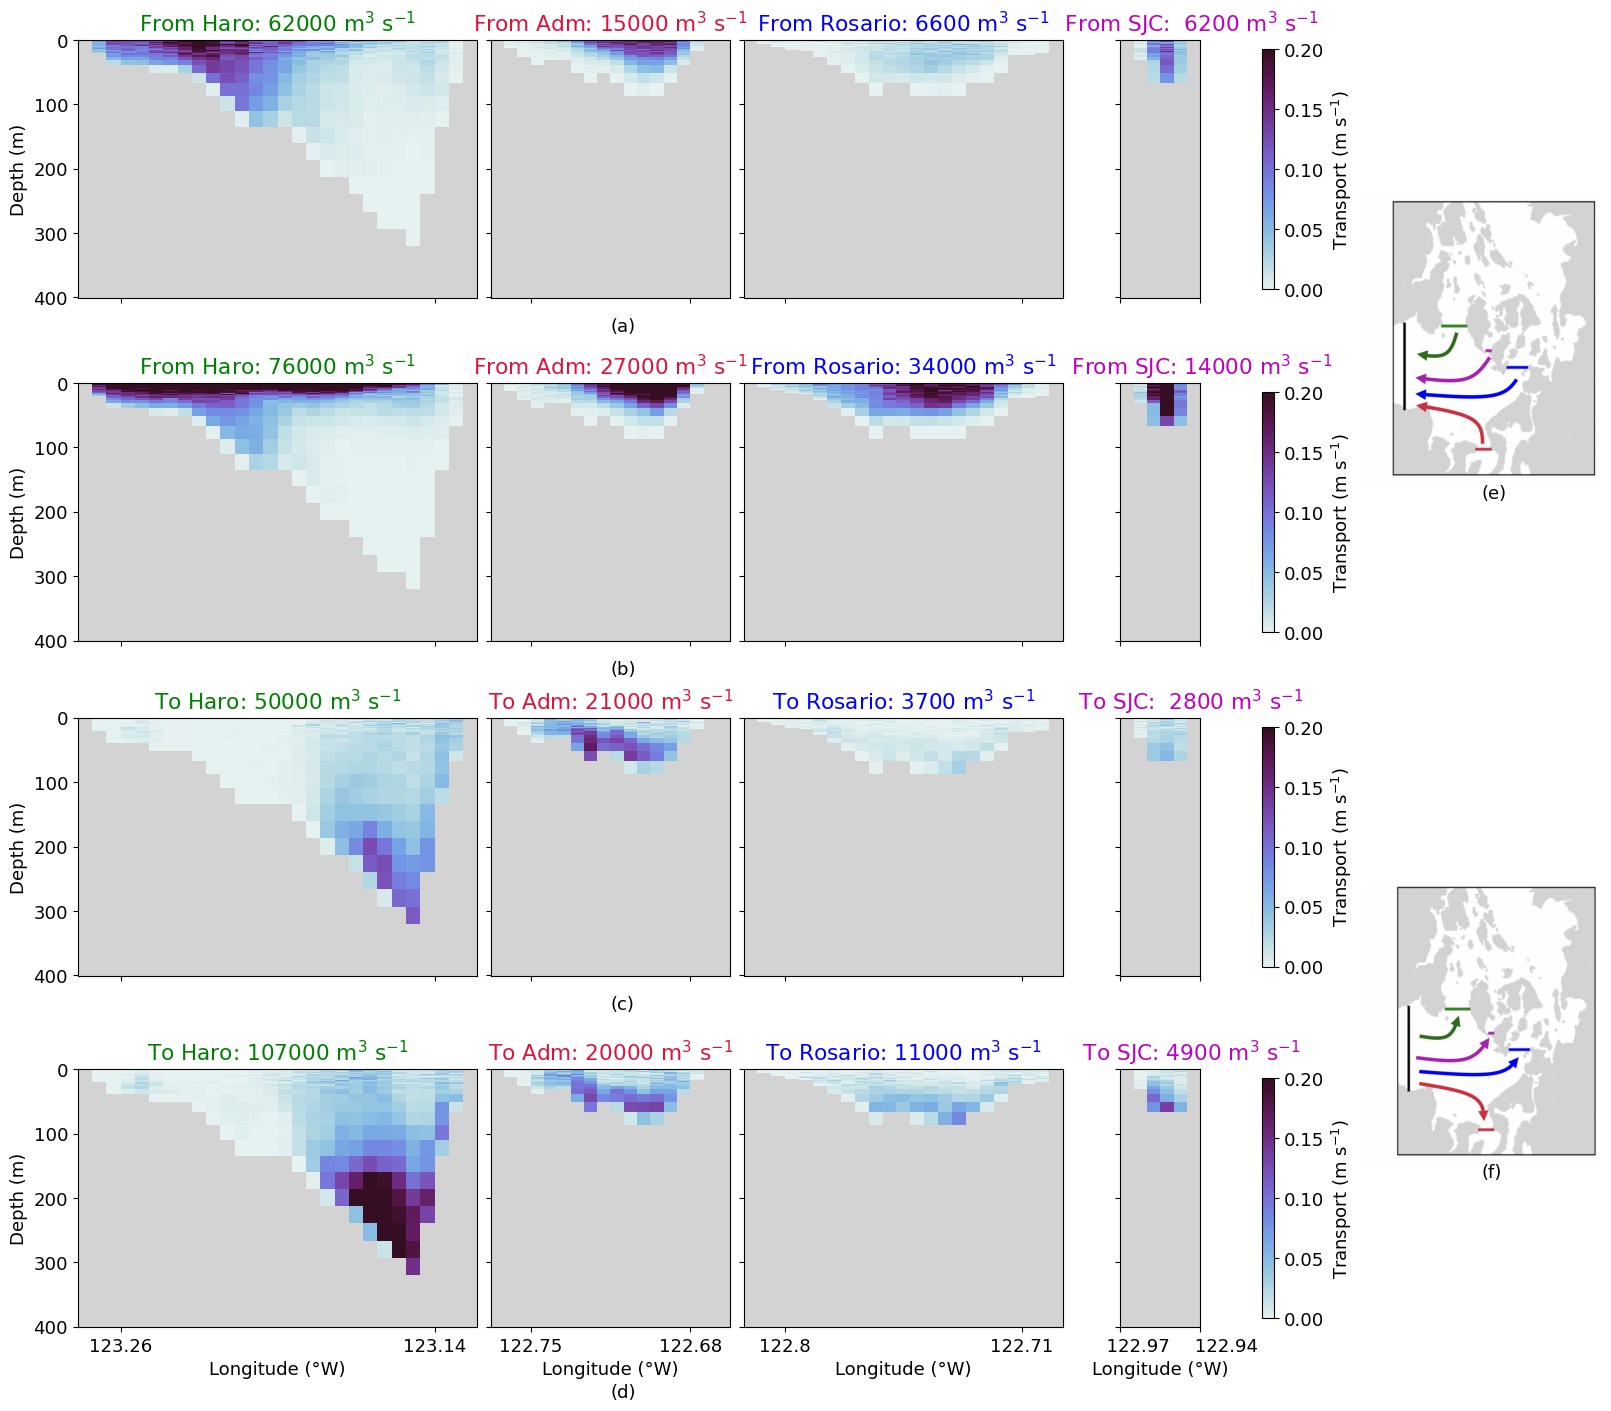

In [13]:
plt.rcParams.update({'font.size': 13})

title = 'From Haro: ' + str(int(np.round(np.sum(dict_all['harotovs3']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-3))) + f' m$^3$ s$^{{-1}}$'
title2 = 'From Rosario: ' + str(int(np.round(np.sum(dict_all['rostovs3']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-2))) + f' m$^3$ s$^{{-1}}$'
title3 = '         From SJC:  ' + str(int(np.round(np.sum(dict_all['sjctovs3']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-2))) + f' m$^3$ s$^{{-1}}$'
title4 = 'From Adm: ' + str(int(np.round(np.sum(dict_all['admtovs3']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-3))) + f' m$^3$ s$^{{-1}}$'

title5 = 'From Haro: ' + str(int(np.round(np.sum(dict_all['harotovs3']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-3))) + f' m$^3$ s$^{{-1}}$'
title6 = 'From Rosario: ' + str(int(np.round(np.sum(dict_all['rostovs3']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-3))) + f' m$^3$ s$^{{-1}}$'
title7 = '            From SJC: ' + str(int(np.round(np.sum(dict_all['sjctovs3']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-3))) + f' m$^3$ s$^{{-1}}$'
title8 = 'From Adm: ' + str(int(np.round(np.sum(dict_all['admtovs3']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-3))) + f' m$^3$ s$^{{-1}}$'

sum = 67
harolen =int(26/sum*14)
roslen = int(21/sum*14)
sjclen = int(5/sum*14)
admlen = int(15/sum*14)
totalallen = harolen+roslen+sjclen+admlen

fig = plt.figure(constrained_layout=True, figsize=[16,14])
gs = GridSpec(4,16, figure=fig)

ax1 = fig.add_subplot(gs[0, :harolen]) 
ax2 = fig.add_subplot(gs[0,harolen:harolen+admlen])
ax3 = fig.add_subplot(gs[0,harolen+admlen:harolen+admlen+roslen])
ax4 = fig.add_subplot(gs[0,harolen+admlen+roslen:harolen+admlen+sjclen+roslen])
ax5 = fig.add_subplot(gs[1, :harolen]) 
ax6 = fig.add_subplot(gs[1,harolen:harolen+admlen])
ax7 = fig.add_subplot(gs[1,harolen+admlen:harolen+roslen+admlen])
ax8 = fig.add_subplot(gs[1,harolen+roslen+admlen:harolen+roslen+sjclen+admlen])
ax9 = fig.add_subplot(gs[2, :harolen]) 
ax10 = fig.add_subplot(gs[2,harolen:harolen+admlen])
ax11 = fig.add_subplot(gs[2,harolen+admlen:harolen+roslen+admlen])
ax12 = fig.add_subplot(gs[2,harolen+roslen+admlen:harolen+roslen+sjclen+admlen])
ax13 = fig.add_subplot(gs[3, :harolen]) 
ax14 = fig.add_subplot(gs[3,harolen:harolen+admlen])
ax15 = fig.add_subplot(gs[3,harolen+admlen:harolen+roslen+admlen])
ax16 = fig.add_subplot(gs[3,harolen+roslen+admlen:harolen+roslen+sjclen+admlen])

ax_center1 = fig.add_subplot(gs[0:2,harolen+roslen+sjclen+admlen:])
ax_center1.imshow(plt.imread('/ocean/cstang/MOAD/analysis-camryn/Figures/map_cs_bvs.png'))
ax_center1.axis('off');

ax_center2 = fig.add_subplot(gs[2:,harolen+roslen+sjclen+admlen:])
ax_center2.imshow(plt.imread('/ocean/cstang/MOAD/analysis-camryn/Figures/map_cs_fvs.png'))
ax_center2.axis('off');

plotCS(ax1,dict_all['harotovs3']['final_lon'][months[idx_dec]].dropna(),dict_all['harotovs3']['final_z'][months[idx_dec]].dropna(),dict_all['harotovs3']['final_transp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_dec],title,False,True)
plotCS(ax3,dict_all['rostovs3']['final_lon'][months[idx_dec]].dropna(),dict_all['rostovs3']['final_z'][months[idx_dec]].dropna(),dict_all['rostovs3']['final_transp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_dec],title2,False,False)
plotCS2(ax4,dict_all['sjctovs3']['final_lon'][months[idx_dec]].dropna(),dict_all['sjctovs3']['final_z'][months[idx_dec]].dropna(),dict_all['sjctovs3']['final_transp'][months[idx_dec]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_dec],title3,True,False)
plotCS(ax2,dict_all['admtovs3']['final_lon'][months[idx_dec]].dropna(),dict_all['admtovs3']['final_z'][months[idx_dec]].dropna(),dict_all['admtovs3']['final_transp'][months[idx_dec]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_dec],title4,False,False)

plotCS(ax5,dict_all['harotovs3']['final_lon'][months[idx_jun]].dropna(),dict_all['harotovs3']['final_z'][months[idx_jun]].dropna(),dict_all['harotovs3']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_jun],title5,False,True)
plotCS(ax7,dict_all['rostovs3']['final_lon'][months[idx_jun]].dropna(),dict_all['rostovs3']['final_z'][months[idx_jun]].dropna(),dict_all['rostovs3']['final_transp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_jun],title6,False,False)
plotCS2(ax8,dict_all['sjctovs3']['final_lon'][months[idx_jun]].dropna(),dict_all['sjctovs3']['final_z'][months[idx_jun]].dropna(),dict_all['sjctovs3']['final_transp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_jun],title7,True,False)
plotCS(ax6,dict_all['admtovs3']['final_lon'][months[idx_jun]].dropna(),dict_all['admtovs3']['final_z'][months[idx_jun]].dropna(),dict_all['admtovs3']['final_transp'][months[idx_jun]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_jun],title8,False,False)

ax1.set_title(title,color='green')
ax2.set_title(title4,color='crimson')
ax3.set_title(title2,color='b')
ax4.set_title(title3,color='m')
ax5.set_title(title5,color='green')
ax6.set_title(title8,color='crimson')
ax7.set_title(title6,color='b')
ax8.set_title(title7,color='m')

title = 'To Haro: ' + str(int(np.round(np.sum(dict_all['vstoharo3']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-3))) + f' m$^3$ s$^{{-1}}$'
title2 = 'To Rosario: ' + str(int(np.round(np.sum(dict_all['vstoros3']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-2))) + f' m$^3$ s$^{{-1}}$'
title3 = '         To SJC:  ' + str(int(np.round(np.sum(dict_all['vstosjc3']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-2))) + f' m$^3$ s$^{{-1}}$'
title4 = 'To Adm: ' + str(int(np.round(np.sum(dict_all['vstoadm3']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-3))) + f' m$^3$ s$^{{-1}}$'

title5 = 'To Haro: ' + str(int(np.round(np.sum(dict_all['vstoharo3']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-3))) + f' m$^3$ s$^{{-1}}$'
title6 = 'To Rosario: ' + str(int(np.round(np.sum(dict_all['vstoros3']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-2))) + f' m$^3$ s$^{{-1}}$'
title7 = '         To SJC: ' + str(int(np.round(np.sum(dict_all['vstosjc3']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-2))) + f' m$^3$ s$^{{-1}}$'
title8 = 'To Adm: ' + str(int(np.round(np.sum(dict_all['vstoadm3']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-3))) + f' m$^3$ s$^{{-1}}$'

plotCS(ax9,dict_all['vstoharo3']['final_lon'][months[idx_dec]].dropna(),dict_all['vstoharo3']['final_z'][months[idx_dec]].dropna(),dict_all['vstoharo3']['final_transp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_dec],title,False,True)
plotCS(ax11,dict_all['vstoros3']['final_lon'][months[idx_dec]].dropna(),dict_all['vstoros3']['final_z'][months[idx_dec]].dropna(),dict_all['vstoros3']['final_transp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_dec],title2,False,False)
plotCS2(ax12,dict_all['vstosjc3']['final_lon'][months[idx_dec]].dropna(),dict_all['vstosjc3']['final_z'][months[idx_dec]].dropna(),dict_all['vstosjc3']['final_transp'][months[idx_dec]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_dec],title3,True,False)
plotCS(ax10,dict_all['vstoadm3']['final_lon'][months[idx_dec]].dropna(),dict_all['vstoadm3']['final_z'][months[idx_dec]].dropna(),dict_all['vstoadm3']['final_transp'][months[idx_dec]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_dec],title4,False,False)

plotCS(ax13,dict_all['vstoharo3']['final_lon'][months[idx_jun]].dropna(),dict_all['vstoharo3']['final_z'][months[idx_jun]].dropna(),dict_all['vstoharo3']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_jun],title5,False,True)
plotCS(ax15,dict_all['vstoros3']['final_lon'][months[idx_jun]].dropna(),dict_all['vstoros3']['final_z'][months[idx_jun]].dropna(),dict_all['vstoros3']['final_transp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_jun],title6,False,False)
plotCS2(ax16,dict_all['vstosjc3']['final_lon'][months[idx_jun]].dropna(),dict_all['vstosjc3']['final_z'][months[idx_jun]].dropna(),dict_all['vstosjc3']['final_transp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_jun],title7,True,False)
plotCS(ax14,dict_all['vstoadm3']['final_lon'][months[idx_jun]].dropna(),dict_all['vstoadm3']['final_z'][months[idx_jun]].dropna(),dict_all['vstoadm3']['final_transp'][months[idx_jun]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_jun],title8,False,False)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('')
ax6.set_xlabel('')
ax7.set_xlabel('')
ax8.set_xlabel('')
ax9.set_xlabel('')
ax10.set_xlabel('')
ax11.set_xlabel('')
ax12.set_xlabel('')

ax9.set_title(title,color='green')
ax10.set_title(title4,color='crimson')
ax11.set_title(title2,color='b')
ax12.set_title(title3,color='m')
ax13.set_title(title5,color='green')
ax14.set_title(title8,color='crimson')
ax15.set_title(title6,color='b')
ax16.set_title(title7,color='m')

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax5.set_xticklabels([])
ax6.set_xticklabels([])
ax7.set_xticklabels([])
ax8.set_xticklabels([])
ax9.set_xticklabels([])
ax10.set_xticklabels([])
ax11.set_xticklabels([])
ax12.set_xticklabels([])

fig.subplots_adjust(wspace=0.12,hspace=0.25)

ax2.text(0.5, -0.13, "(a)", transform=ax2.transAxes)
ax6.text(0.5, -0.13, "(b)", transform=ax6.transAxes)
ax10.text(0.5, -0.13, "(c)", transform=ax10.transAxes)
ax14.text(0.5, -0.27, "(d)", transform=ax14.transAxes)
ax_center1.text(0.5, -0.05, "(e)", transform=ax_center1.transAxes)
ax_center2.text(0.5, -0.05, "(f)", transform=ax_center2.transAxes)

In [14]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/ejdf_sections_wmap.png',bbox_inches='tight')

### For slides

/tmp/ipykernel_2779136/3495444298.py:112: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.12,hspace=0.25)


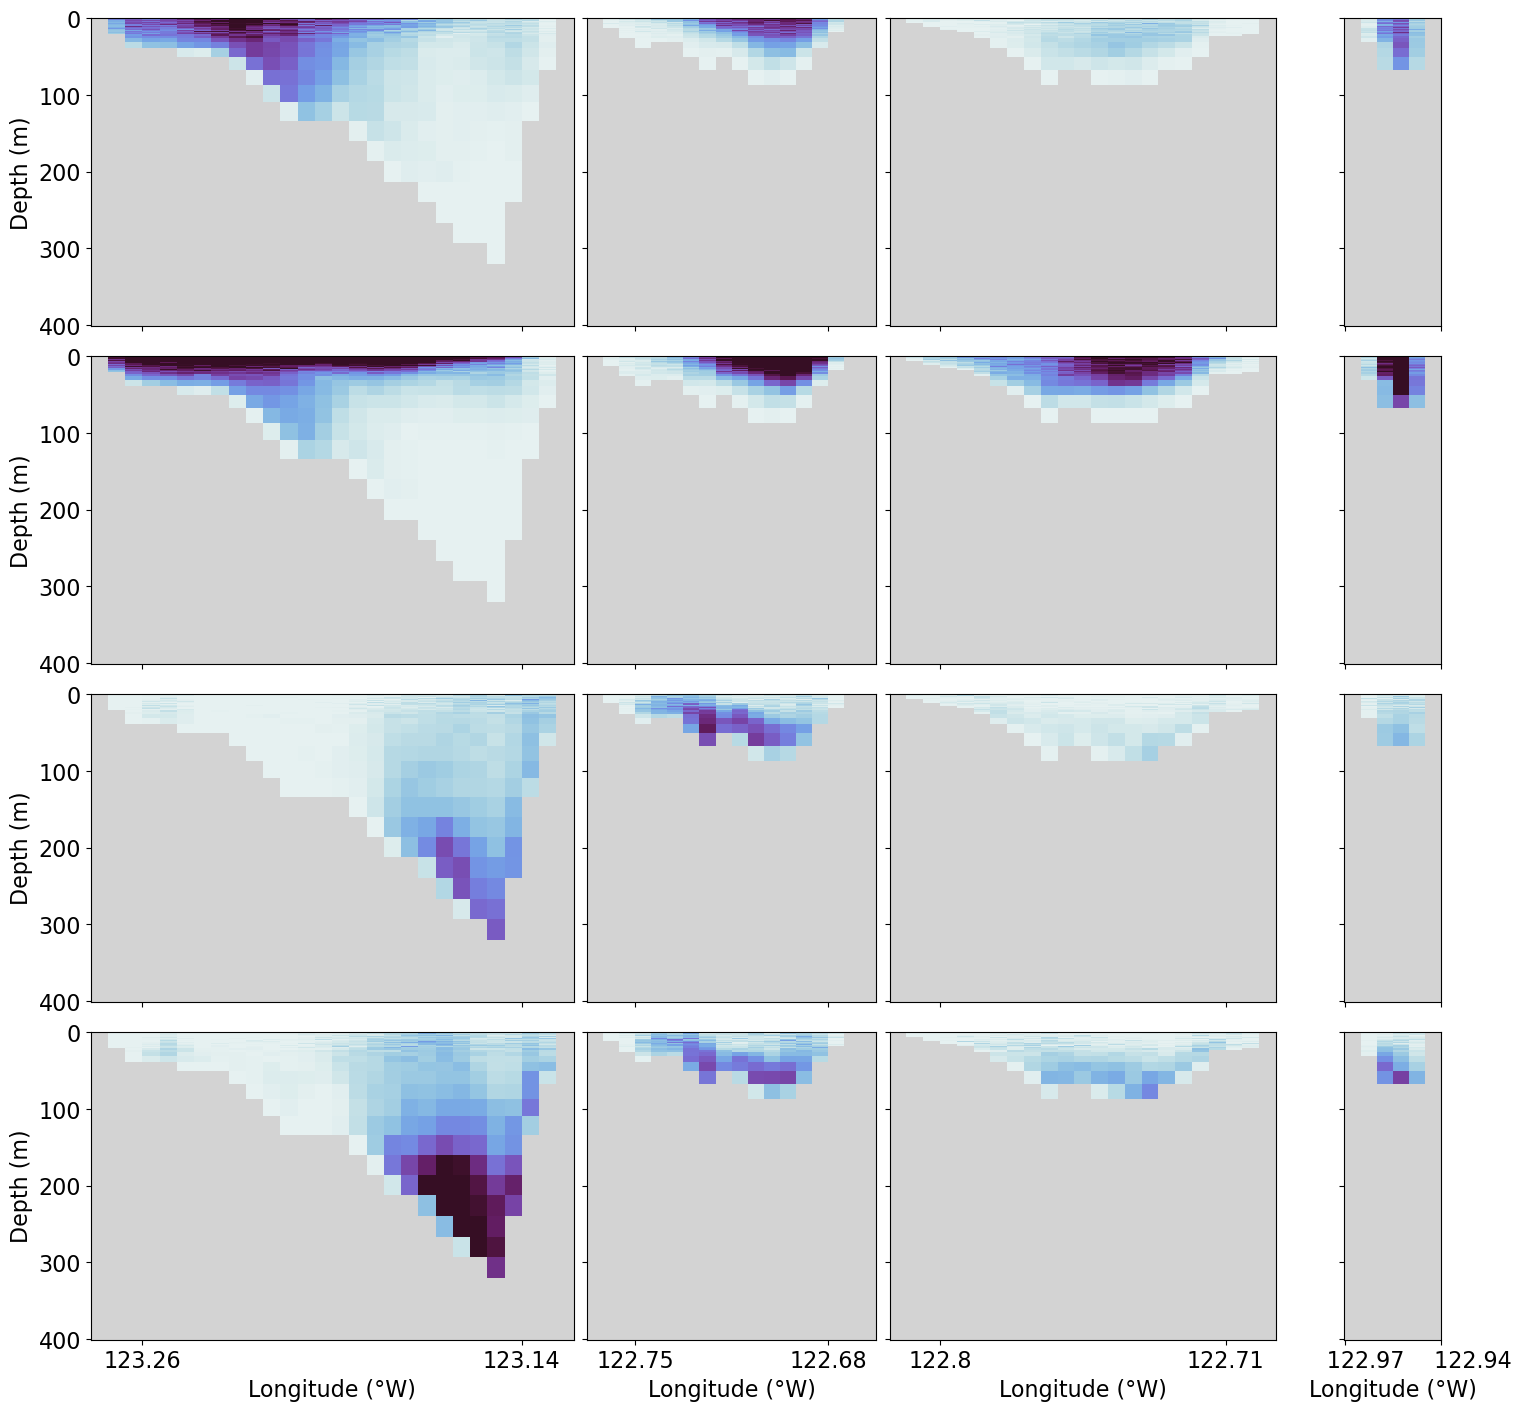

In [15]:
plt.rcParams.update({'font.size': 16})

title = ''
title2 = ''
title3 = ''
title4 = ''

title5 = ''
title6 = ''
title7 = ''
title8 = ''

sum = 67
harolen =int(26/sum*14)
roslen = int(21/sum*14)
sjclen = int(5/sum*14)
admlen = int(15/sum*14)
totalallen = harolen+roslen+sjclen+admlen

fig = plt.figure(constrained_layout=True, figsize=[18,14])
gs = GridSpec(4,16, figure=fig)

ax1 = fig.add_subplot(gs[0, :harolen]) 
ax2 = fig.add_subplot(gs[0,harolen:harolen+admlen])
ax3 = fig.add_subplot(gs[0,harolen+admlen:harolen+admlen+roslen])
ax4 = fig.add_subplot(gs[0,harolen+admlen+roslen:harolen+admlen+sjclen+roslen])
ax5 = fig.add_subplot(gs[1, :harolen]) 
ax6 = fig.add_subplot(gs[1,harolen:harolen+admlen])
ax7 = fig.add_subplot(gs[1,harolen+admlen:harolen+roslen+admlen])
ax8 = fig.add_subplot(gs[1,harolen+roslen+admlen:harolen+roslen+sjclen+admlen])
ax9 = fig.add_subplot(gs[2, :harolen]) 
ax10 = fig.add_subplot(gs[2,harolen:harolen+admlen])
ax11 = fig.add_subplot(gs[2,harolen+admlen:harolen+roslen+admlen])
ax12 = fig.add_subplot(gs[2,harolen+roslen+admlen:harolen+roslen+sjclen+admlen])
ax13 = fig.add_subplot(gs[3, :harolen]) 
ax14 = fig.add_subplot(gs[3,harolen:harolen+admlen])
ax15 = fig.add_subplot(gs[3,harolen+admlen:harolen+roslen+admlen])
ax16 = fig.add_subplot(gs[3,harolen+roslen+admlen:harolen+roslen+sjclen+admlen])

# ax_center1 = fig.add_subplot(gs[0:2,harolen+roslen+sjclen+admlen:])
# ax_center1.imshow(plt.imread('/ocean/cstang/MOAD/analysis-camryn/Figures/map_cs_bvs.png'))
# ax_center1.axis('off');

# ax_center2 = fig.add_subplot(gs[2:,harolen+roslen+sjclen+admlen:])
# ax_center2.imshow(plt.imread('/ocean/cstang/MOAD/analysis-camryn/Figures/map_cs_fvs.png'))
# ax_center2.axis('off');

plotCS(ax1,dict_all['harotovs3']['final_lon'][months[idx_dec]].dropna(),dict_all['harotovs3']['final_z'][months[idx_dec]].dropna(),dict_all['harotovs3']['final_transp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_dec],'',False,True)
plotCS(ax3,dict_all['rostovs3']['final_lon'][months[idx_dec]].dropna(),dict_all['rostovs3']['final_z'][months[idx_dec]].dropna(),dict_all['rostovs3']['final_transp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_dec],'',False,False)
plotCS2(ax4,dict_all['sjctovs3']['final_lon'][months[idx_dec]].dropna(),dict_all['sjctovs3']['final_z'][months[idx_dec]].dropna(),dict_all['sjctovs3']['final_transp'][months[idx_dec]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_dec],'',False,False)
plotCS(ax2,dict_all['admtovs3']['final_lon'][months[idx_dec]].dropna(),dict_all['admtovs3']['final_z'][months[idx_dec]].dropna(),dict_all['admtovs3']['final_transp'][months[idx_dec]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_dec],'',False,False)

plotCS(ax5,dict_all['harotovs3']['final_lon'][months[idx_jun]].dropna(),dict_all['harotovs3']['final_z'][months[idx_jun]].dropna(),dict_all['harotovs3']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_jun],'',False,True)
plotCS(ax7,dict_all['rostovs3']['final_lon'][months[idx_jun]].dropna(),dict_all['rostovs3']['final_z'][months[idx_jun]].dropna(),dict_all['rostovs3']['final_transp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_jun],'',False,False)
plotCS2(ax8,dict_all['sjctovs3']['final_lon'][months[idx_jun]].dropna(),dict_all['sjctovs3']['final_z'][months[idx_jun]].dropna(),dict_all['sjctovs3']['final_transp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_jun],'',False,False)
plotCS(ax6,dict_all['admtovs3']['final_lon'][months[idx_jun]].dropna(),dict_all['admtovs3']['final_z'][months[idx_jun]].dropna(),dict_all['admtovs3']['final_transp'][months[idx_jun]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_jun],'',False,False)

ax1.set_title(title,color='green')
ax2.set_title(title4,color='crimson')
ax3.set_title(title2,color='b')
ax4.set_title(title3,color='m')
ax5.set_title(title5,color='green')
ax6.set_title(title8,color='crimson')
ax7.set_title(title6,color='b')
ax8.set_title(title7,color='m')

plotCS(ax9,dict_all['vstoharo3']['final_lon'][months[idx_dec]].dropna(),dict_all['vstoharo3']['final_z'][months[idx_dec]].dropna(),dict_all['vstoharo3']['final_transp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_dec],'',False,True)
plotCS(ax11,dict_all['vstoros3']['final_lon'][months[idx_dec]].dropna(),dict_all['vstoros3']['final_z'][months[idx_dec]].dropna(),dict_all['vstoros3']['final_transp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_dec],'',False,False)
plotCS2(ax12,dict_all['vstosjc3']['final_lon'][months[idx_dec]].dropna(),dict_all['vstosjc3']['final_z'][months[idx_dec]].dropna(),dict_all['vstosjc3']['final_transp'][months[idx_dec]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_dec],'',False,False)
plotCS(ax10,dict_all['vstoadm3']['final_lon'][months[idx_dec]].dropna(),dict_all['vstoadm3']['final_z'][months[idx_dec]].dropna(),dict_all['vstoadm3']['final_transp'][months[idx_dec]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_dec],'',False,False)

plotCS(ax13,dict_all['vstoharo3']['final_lon'][months[idx_jun]].dropna(),dict_all['vstoharo3']['final_z'][months[idx_jun]].dropna(),dict_all['vstoharo3']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_jun],'',False,True)
plotCS(ax15,dict_all['vstoros3']['final_lon'][months[idx_jun]].dropna(),dict_all['vstoros3']['final_z'][months[idx_jun]].dropna(),dict_all['vstoros3']['final_transp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_jun],'',False,False)
plotCS2(ax16,dict_all['vstosjc3']['final_lon'][months[idx_jun]].dropna(),dict_all['vstosjc3']['final_z'][months[idx_jun]].dropna(),dict_all['vstosjc3']['final_transp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_jun],'',False,False)
plotCS(ax14,dict_all['vstoadm3']['final_lon'][months[idx_jun]].dropna(),dict_all['vstoadm3']['final_z'][months[idx_jun]].dropna(),dict_all['vstoadm3']['final_transp'][months[idx_jun]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_jun],'',False,False)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('')
ax6.set_xlabel('')
ax7.set_xlabel('')
ax8.set_xlabel('')
ax9.set_xlabel('')
ax10.set_xlabel('')
ax11.set_xlabel('')
ax12.set_xlabel('')

ax9.set_title(title,color='green')
ax10.set_title(title4,color='crimson')
ax11.set_title(title2,color='b')
ax12.set_title(title3,color='m')
ax13.set_title(title5,color='green')
ax14.set_title(title8,color='crimson')
ax15.set_title(title6,color='b')
ax16.set_title(title7,color='m')

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax5.set_xticklabels([])
ax6.set_xticklabels([])
ax7.set_xticklabels([])
ax8.set_xticklabels([])
ax9.set_xticklabels([])
ax10.set_xticklabels([])
ax11.set_xticklabels([])
ax12.set_xticklabels([])

fig.subplots_adjust(wspace=0.12,hspace=0.25)

# ax2.text(0.5, -0.13, "(a)", transform=ax2.transAxes)
# ax6.text(0.5, -0.13, "(b)", transform=ax6.transAxes)
# ax10.text(0.5, -0.13, "(c)", transform=ax10.transAxes)
# ax14.text(0.5, -0.27, "(d)", transform=ax14.transAxes)
# ax_center1.text(0.5, -0.05, "(e)", transform=ax_center1.transAxes)
# ax_center2.text(0.5, -0.05, "(f)", transform=ax_center2.transAxes)

/tmp/ipykernel_2779136/429142989.py:52: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.12,hspace=0.25)


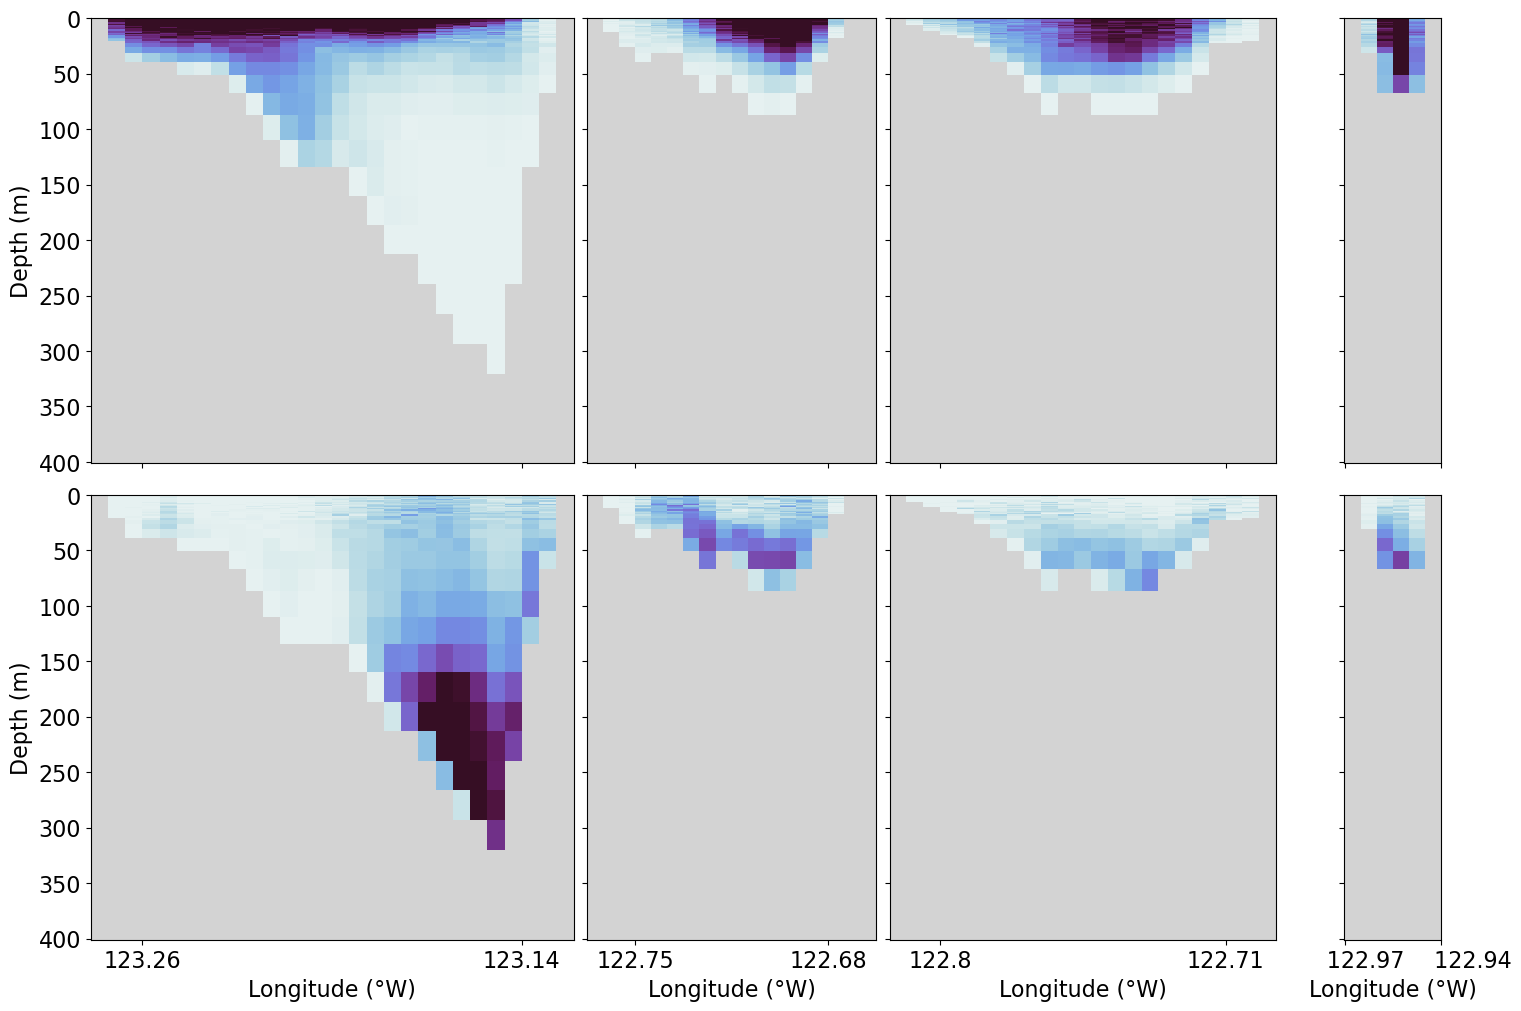

In [16]:
plt.rcParams.update({'font.size': 16})

title = ''
title2 = ''
title3 = ''
title4 = ''

title5 = ''
title6 = ''
title7 = ''
title8 = ''

sum = 67
harolen =int(26/sum*14)
roslen = int(21/sum*14)
sjclen = int(5/sum*14)
admlen = int(15/sum*14)
totalallen = harolen+roslen+sjclen+admlen

fig = plt.figure(constrained_layout=True, figsize=[18,10])
gs = GridSpec(2,16, figure=fig)

ax1 = fig.add_subplot(gs[0, :harolen]) 
ax2 = fig.add_subplot(gs[0,harolen:harolen+admlen])
ax3 = fig.add_subplot(gs[0,harolen+admlen:harolen+admlen+roslen])
ax4 = fig.add_subplot(gs[0,harolen+admlen+roslen:harolen+admlen+sjclen+roslen])
ax5 = fig.add_subplot(gs[1, :harolen]) 
ax6 = fig.add_subplot(gs[1,harolen:harolen+admlen])
ax7 = fig.add_subplot(gs[1,harolen+admlen:harolen+roslen+admlen])
ax8 = fig.add_subplot(gs[1,harolen+roslen+admlen:harolen+roslen+sjclen+admlen])

plotCS(ax1,dict_all['harotovs3']['final_lon'][months[idx_jun]].dropna(),dict_all['harotovs3']['final_z'][months[idx_jun]].dropna(),dict_all['harotovs3']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_jun],'',False,True)
plotCS(ax3,dict_all['rostovs3']['final_lon'][months[idx_jun]].dropna(),dict_all['rostovs3']['final_z'][months[idx_jun]].dropna(),dict_all['rostovs3']['final_transp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_jun],'',False,False)
plotCS2(ax4,dict_all['sjctovs3']['final_lon'][months[idx_jun]].dropna(),dict_all['sjctovs3']['final_z'][months[idx_jun]].dropna(),dict_all['sjctovs3']['final_transp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_jun],'',False,False)
plotCS(ax2,dict_all['admtovs3']['final_lon'][months[idx_jun]].dropna(),dict_all['admtovs3']['final_z'][months[idx_jun]].dropna(),dict_all['admtovs3']['final_transp'][months[idx_jun]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_jun],'',False,False)

plotCS(ax5,dict_all['vstoharo3']['final_lon'][months[idx_jun]].dropna(),dict_all['vstoharo3']['final_z'][months[idx_jun]].dropna(),dict_all['vstoharo3']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_jun],'',False,True)
plotCS(ax7,dict_all['vstoros3']['final_lon'][months[idx_jun]].dropna(),dict_all['vstoros3']['final_z'][months[idx_jun]].dropna(),dict_all['vstoros3']['final_transp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_jun],'',False,False)
plotCS2(ax8,dict_all['vstosjc3']['final_lon'][months[idx_jun]].dropna(),dict_all['vstosjc3']['final_z'][months[idx_jun]].dropna(),dict_all['vstosjc3']['final_transp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_jun],'',False,False)
plotCS(ax6,dict_all['vstoadm3']['final_lon'][months[idx_jun]].dropna(),dict_all['vstoadm3']['final_z'][months[idx_jun]].dropna(),dict_all['vstoadm3']['final_transp'][months[idx_jun]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_jun],'',False,False)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])

fig.subplots_adjust(wspace=0.12,hspace=0.25)

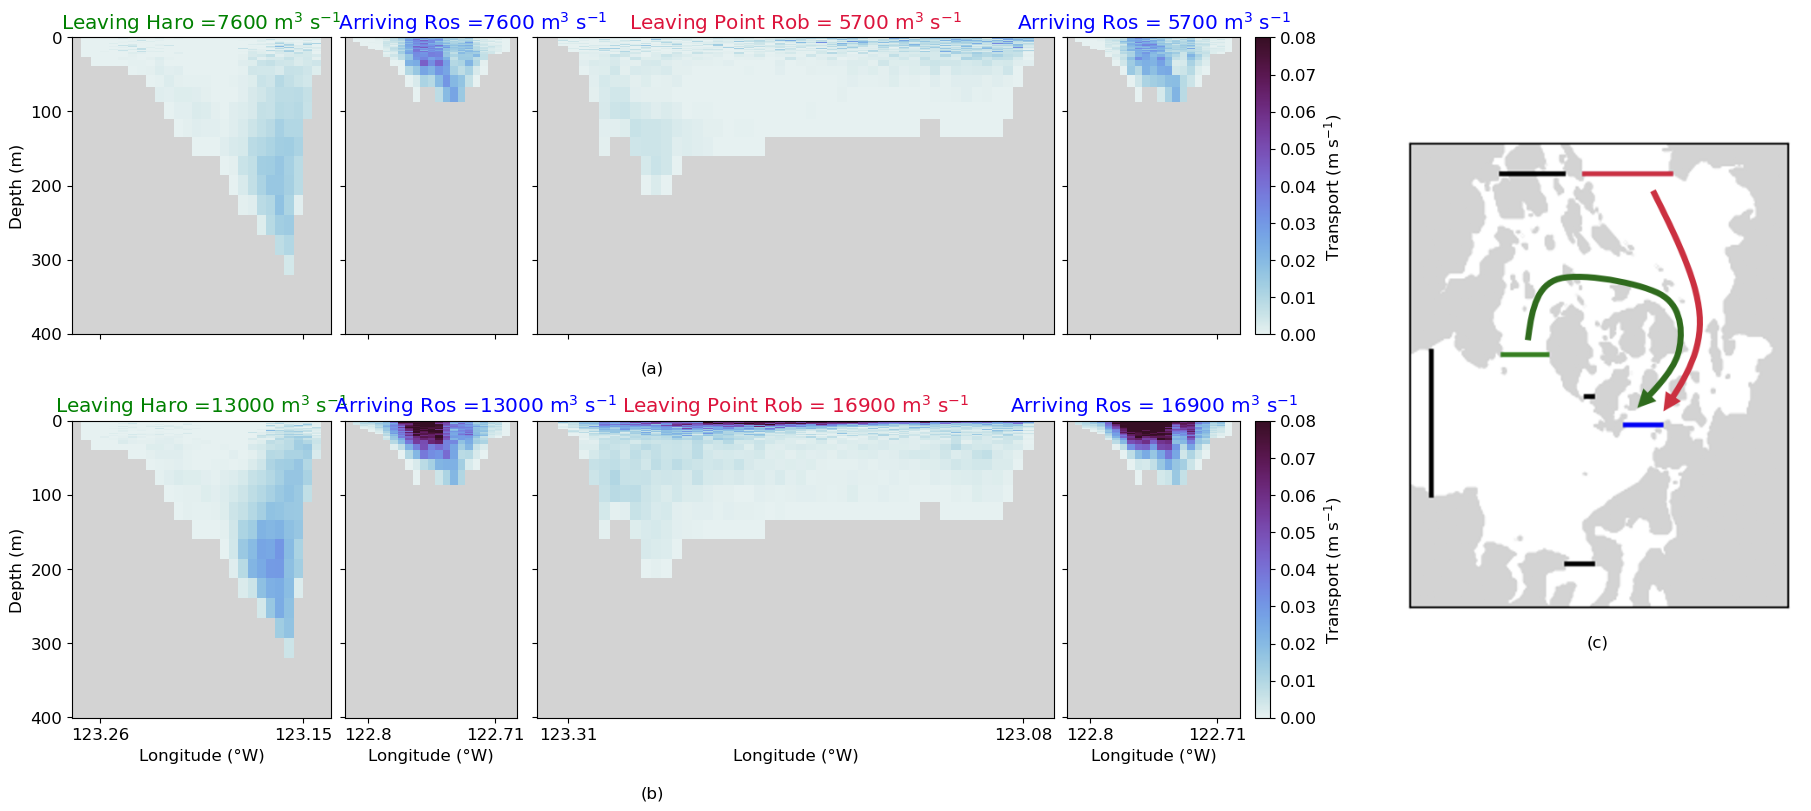

In [17]:
plt.rcParams.update({'font.size': 12})

latharoB = 301
sum = 116
harolen =int(26/sum*16)
roslen = int(21/sum*16)
prlen = int(48/sum*16)
totalallen = harolen+roslen+prlen+roslen

fig = plt.figure(constrained_layout=True, figsize=[18,8])
gs = GridSpec(2,18, figure=fig)

ax1 = fig.add_subplot(gs[0, :harolen]) 
ax2 = fig.add_subplot(gs[0,harolen:harolen+roslen])
ax3 = fig.add_subplot(gs[0,harolen+roslen:harolen+roslen+prlen])
ax4 = fig.add_subplot(gs[0,harolen+roslen+prlen:harolen+roslen+prlen+roslen])
ax5 = fig.add_subplot(gs[1, :harolen]) 
ax6 = fig.add_subplot(gs[1,harolen:harolen+roslen])
ax7 = fig.add_subplot(gs[1,harolen+roslen:harolen+roslen+prlen])
ax8 = fig.add_subplot(gs[1,harolen+roslen+prlen:harolen+roslen+prlen+roslen])

title = f'Leaving Haro =' + str(int(np.round(np.sum(dict_all['harotoros']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-2))) + f' m$^3$ s$^{{-1}}$'
title2 = f'             Arriving Ros =' + str(int(np.round(np.sum(dict_all['harotoros']['init_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-2))) + f' m$^3$ s$^{{-1}}$'
title3 = f'Leaving Point Rob = ' + str(int(np.round(np.sum(dict_all['prtoros_RS']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-2))) + f' m$^3$ s$^{{-1}}$'
title4 = f'Arriving Ros = ' + str(int(np.round(np.sum(dict_all['prtoros_RS']['init_transp'][months[idx_dec]])/(23*days_month[idx_dec]),-2))) + f' m$^3$ s$^{{-1}}$'
# title4 = 'Arriving Ros = ' + str(np.round(np.sum(dict_all['sjctoros']['final_transp'][months[idx_dec]])/(23*days_month[idx_dec]))) + f' m$^3$/s'

title5 = f'Leaving Haro =' + str(int(np.round(np.sum(dict_all['harotoros']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-3))) + f' m$^3$ s$^{{-1}}$'
title6 = f'              Arriving Ros =' + str(int(np.round(np.sum(dict_all['harotoros']['init_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-3))) + f' m$^3$ s$^{{-1}}$'
title7 = f'Leaving Point Rob = ' + str(int(np.round(np.sum(dict_all['prtoros_RS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-2))) + f' m$^3$ s$^{{-1}}$'
title8 = f'Arriving Ros = ' + str(int(np.round(np.sum(dict_all['prtoros_RS']['init_transp'][months[idx_jun]])/(23*days_month[idx_jun]),-2))) + f' m$^3$ s$^{{-1}}$'

ax_center1 = fig.add_subplot(gs[:, harolen+roslen+prlen+roslen:])
ax_center1.imshow(plt.imread('/ocean/cstang/MOAD/analysis-camryn/Figures/map_cs_bros.png'))
ax_center1.axis('off');

plotCS(ax1,dict_all['harotoros']['final_lon'][months[idx_dec]].dropna(),dict_all['harotoros']['final_z'][months[idx_dec]].dropna(),dict_all['harotoros']['final_transp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharoB,38,0.08,23*days_month[idx_dec],title,False,True)
plotCS(ax2,dict_all['harotoros']['init_lon'][months[idx_dec]].dropna(),dict_all['harotoros']['init_z'][months[idx_dec]].dropna(),dict_all['harotoros']['init_transp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.08,23*days_month[idx_dec],title2,False,False)
plotCS(ax3,dict_all['prtoros_RS']['final_lon'][months[idx_dec]].dropna(),dict_all['prtoros_RS']['final_z'][months[idx_dec]].dropna(),dict_all['prtoros_RS']['final_transp'][months[idx_dec]].dropna(),lonWpr,lonEpr,latpr,38,0.08,23*days_month[idx_dec],title3,False,False)
plotCS(ax4,dict_all['prtoros_RS']['init_lon'][months[idx_dec]].dropna(),dict_all['prtoros_RS']['init_z'][months[idx_dec]].dropna(),dict_all['prtoros_RS']['init_transp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.08,23*days_month[idx_dec],title4,True,False)
# plotCS(ax4,dict_all['prtoros']['final_lon'][months[idx_dec]].dropna(),dict_all['prtoros']['final_z'][months[idx_dec]].dropna(),dict_all['prtoros']['final_transp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.08,23*days_month[idx_dec],title4,True,False)

# plotCS2(ax2,dict_all['harotoros']['final_lon'][months[idx_jun]].dropna(),dict_all['harotoros']['final_z'][months[idx_jun]].dropna(),dict_all['harotoros']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharoB,38,0.08,23*days_month[idx_jun],title5,False,False)
plotCS(ax5,dict_all['harotoros']['final_lon'][months[idx_jun]].dropna(),dict_all['harotoros']['final_z'][months[idx_jun]].dropna(),dict_all['harotoros']['final_transp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharoB,38,0.08,23*days_month[idx_jun],title5,False,True)
plotCS(ax6,dict_all['harotoros']['init_lon'][months[idx_jun]].dropna(),dict_all['harotoros']['init_z'][months[idx_jun]].dropna(),dict_all['harotoros']['init_transp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.08,23*days_month[idx_jun],title5,False,False)
plotCS(ax7,dict_all['prtoros_RS']['final_lon'][months[idx_jun]].dropna(),dict_all['prtoros_RS']['final_z'][months[idx_jun]].dropna(),dict_all['prtoros_RS']['final_transp'][months[idx_jun]].dropna(),lonWpr,lonEpr,latpr,38,0.08,23*days_month[idx_jun],title7,False,False)
plotCS(ax8,dict_all['prtoros_RS']['init_lon'][months[idx_jun]].dropna(),dict_all['prtoros_RS']['init_z'][months[idx_jun]].dropna(),dict_all['prtoros_RS']['init_transp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.08,23*days_month[idx_jun],title8,True,False)

# plt.suptitle('Backwards rosario seeding')

ax1.set_title(title,color='green')
ax2.set_title(title2,color='b')
ax3.set_title(title3,color='crimson')
ax4.set_title(title4,color='b')
ax5.set_title(title5,color='green')
ax6.set_title(title6,color='b')
ax7.set_title(title7,color='crimson')
ax8.set_title(title8,color='b')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax1.set_xticklabels('')
ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('');

ax3.text(0.2, -0.13, "(a)", transform=ax3.transAxes)
ax7.text(0.2, -0.27, "(b)", transform=ax7.transAxes)
ax_center1.text(0.5, -0.05, "(c)", transform=ax_center1.transAxes);

In [18]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/cs_ros_wmap.png',bbox_inches='tight')

### Add salinity contours

In [19]:
jgrid = 300
tmask = mesh.tmask[0]

salinity = np.zeros_like(np.array(tmask[:, jgrid]))

salfiles = [xr.open_dataset(f'/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_grid_T_20180101_20180131.nc'),
                xr.open_dataset(f'/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_grid_T_20180701_20180731.nc')]


salinity_haro = np.ma.array(salfiles[0].vosaline[0, :, latharo],
                     mask=1-tmask[:, latharo])


salinity_ros = np.ma.array(salfiles[0].vosaline[0, :, latros],
                     mask=1-tmask[:, latros])

salinity_sjc = np.ma.array(salfiles[1].vosaline[0, :, latsjc],
                     mask=1-tmask[:, latsjc])

In [20]:
jgrid = 300
tmask = mesh.tmask[0]


densfiles = [xr.open_dataset(f'/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_grid_T_20180101_20180131.nc'),
                xr.open_dataset(f'/results2/SalishSea/month-avg.202111/SalishSeaCast_1m_grid_T_20180701_20180731.nc')]


dens_haro = np.ma.array(densfiles[0].sigma_theta[0, :, latharo],
                     mask=1-tmask[:, latharo])


dens_ros = np.ma.array(densfiles[0].sigma_theta[0, :, latros],
                     mask=1-tmask[:, latros])

dens_sjc = np.ma.array(densfiles[1].sigma_theta[0, :, latsjc],
                     mask=1-tmask[:, latsjc])

In [21]:
CBros_Jan = [23.255,23.425,23.5]
CBsjc_Jan = [23.695]
CBgulf_Jan = [23.0,23.4]
CBharo_Jan = [23.7,23.8,23.9,24.0,24.1,24.2]
CBadm_Jan = [23.3,23.64,23.9]

CBros_Jul = [22.5,23.0,23.5]
CBsjc_Jul = [22.7]
CBgulf_Jul = [21.7,23.4]
CBharo_Jul = [23.1,23.6,24.1,24.6,25.1]
CBadm_Jul = [23.2,23.74,24.0]

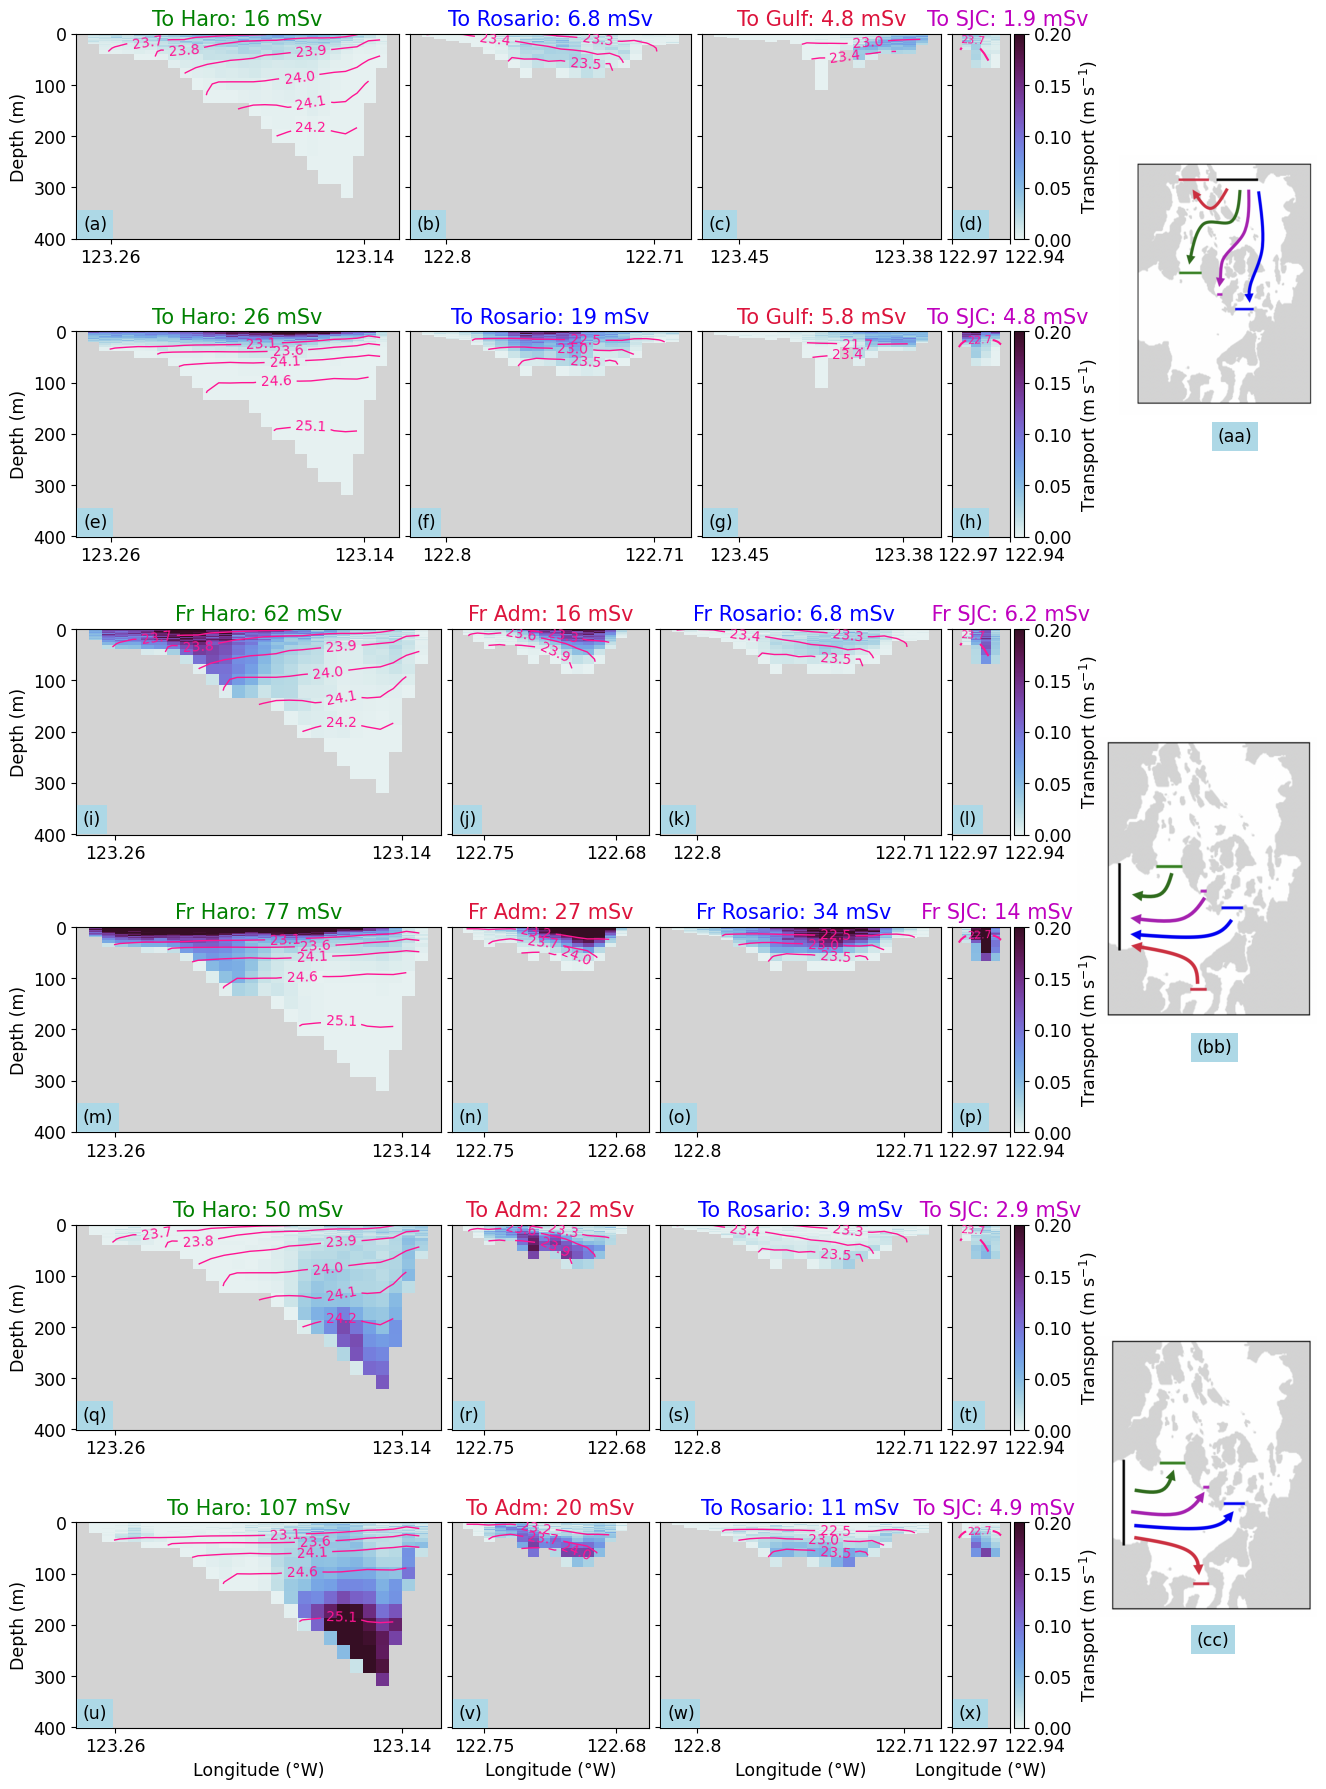

In [22]:
plt.rcParams.update({'font.size': 12.5})

# HERE

title = 'To Haro: ' + str(int(np.round(np.sum(dict_split['prtoharoF']['finaltransp'][months[idx_dec]])/(23*days_month[idx_dec]),-3)/1000)) + f' mSv'
title2 = 'To Rosario: ' + str(np.round(np.sum(dict_split['prtorosF']['finaltransp'][months[idx_dec]])/(23*days_month[idx_dec]),-2)/1000) + f' mSv'
title3 = '        To SJC: ' + str(np.round(np.sum(dict_split['prtosjcF']['finaltransp'][months[idx_dec]])/(23*days_month[idx_dec]),-2)/1000) + f' mSv'
title4 = 'To Gulf: ' + str(np.round(np.sum(dict_split['prtogulfF']['finaltransp'][months[idx_dec]])/(23*days_month[idx_dec]),-2)/1000) + f' mSv'

title5 = 'To Haro: ' + str(int(np.round(np.sum(dict_split['prtoharoF']['finaltransp'][months[idx_jun]])/(23*days_month[idx_jun]),-3)/1000)) + f' mSv'
title6 = 'To Rosario: ' + str(int(np.round(np.sum(dict_split['prtorosF']['finaltransp'][months[idx_jun]])/(23*days_month[idx_jun]),-3)/1000)) + f' mSv'
title7 = '        To SJC: ' + str(np.round(np.sum(dict_split['prtosjcF']['finaltransp'][months[idx_jun]])/(23*days_month[idx_jun]),-2)/1000) + f' mSv'
title8 = 'To Gulf: ' + str(np.round(np.sum(dict_split['prtogulfF']['finaltransp'][months[idx_jun]])/(23*days_month[idx_jun]),-2)/1000) + f' mSv'

##SJGI widths (with gulf)
sum = 70+3
harolen =int(26/sum*25)
roslen = int(21/sum*25)
sjclen = int((5+3)/sum*25)
gulflen = int(18/sum*25)
totalallen = harolen+roslen+sjclen+gulflen

fig = plt.figure( figsize=[16,22])
gs = GridSpec(6,30,figure=fig)
# gs_parent = fig.add_gridspec(2, 1, height_ratios=[0.33, 0.67], hspace=0.13)
# gs_top = gs_parent[0].subgridspec(2, 16, width_ratios=[1, 1, 1, 1.2], hspace=0.25, wspace=0.2)
# gs_bottom = gs_parent[1].subgridspec(4, 16, width_ratios=[1, 1, 1, 1.2], hspace=0.25, wspace=0.12)

ax1 = fig.add_subplot(gs[0, :harolen]) 
ax2 = fig.add_subplot(gs[0,harolen:harolen+roslen])
ax3 = fig.add_subplot(gs[0,harolen+roslen:harolen+roslen+gulflen])
ax4 = fig.add_subplot(gs[0,harolen+roslen+gulflen:harolen+roslen+gulflen+sjclen])
ax5 = fig.add_subplot(gs[1, :harolen]) 
ax6 = fig.add_subplot(gs[1,harolen:harolen+roslen])
ax7 = fig.add_subplot(gs[1,harolen+roslen:harolen+roslen+gulflen])
ax8 = fig.add_subplot(gs[1,harolen+roslen+gulflen:harolen+roslen+gulflen+sjclen])

############
#SJGI
############


ax_center = fig.add_subplot(gs[:2,harolen+roslen+gulflen+sjclen+2: ])
ax_center.imshow(plt.imread('/ocean/cstang/MOAD/analysis-camryn/Figures/map_cs_fpr.png'),zorder=0)
ax_center.axis('off');

plotCS(ax1,dict_split['prtoharoF']['finallon'][months[idx_dec]].dropna(),dict_split['prtoharoF']['finalz'][months[idx_dec]].dropna(),dict_split['prtoharoF']['finaltransp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_dec],title,False,True,contours=True,Cbins=CBharo_Jan)
plotCS(ax2,dict_split['prtorosF']['finallon'][months[idx_dec]].dropna(),dict_split['prtorosF']['finalz'][months[idx_dec]].dropna(),dict_split['prtorosF']['finaltransp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_dec],title2,False,False,contours=True,Cbins=CBros_Jan)
plotCS2(ax4,dict_split['prtosjcF']['finallon'][months[idx_dec]].dropna(),dict_split['prtosjcF']['finalz'][months[idx_dec]].dropna(),dict_split['prtosjcF']['finaltransp'][months[idx_dec]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_dec],title3,True,False,contours=True,Cbins=CBsjc_Jan)
plotCS(ax3,dict_split['prtogulfF']['finallon'][months[idx_dec]].dropna(),dict_split['prtogulfF']['finalz'][months[idx_dec]].dropna(),dict_split['prtogulfF']['finaltransp'][months[idx_dec]].dropna(),lonWg1,lonEg1,latg1,38,0.2,23*days_month[idx_dec],title4,False,False,contours=True,Cbins=CBgulf_Jan)

plotCS(ax5,dict_split['prtoharoF']['finallon'][months[idx_jun]].dropna(),dict_split['prtoharoF']['finalz'][months[idx_jun]].dropna(),dict_split['prtoharoF']['finaltransp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_jun],title5,False,True,contours=True,Cbins=CBharo_Jul,Cidx=1)
plotCS(ax6,dict_split['prtorosF']['finallon'][months[idx_jun]].dropna(),dict_split['prtorosF']['finalz'][months[idx_jun]].dropna(),dict_split['prtorosF']['finaltransp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_jun],title6,False,False,contours=True,Cidx=1,Cbins=CBros_Jul)
plotCS2(ax8,dict_split['prtosjcF']['finallon'][months[idx_jun]].dropna(),dict_split['prtosjcF']['finalz'][months[idx_jun]].dropna(),dict_split['prtosjcF']['finaltransp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_jun],title7,True,False,contours=True,Cidx=1,Cbins=CBsjc_Jul)
plotCS(ax7,dict_split['prtogulfF']['finallon'][months[idx_jun]].dropna(),dict_split['prtogulfF']['finalz'][months[idx_jun]].dropna(),dict_split['prtogulfF']['finaltransp'][months[idx_jun]].dropna(),lonWg1,lonEg1,latg1,38,0.2,23*days_month[idx_jun],title8,False,False,contours=True,Cidx=1,Cbins=CBgulf_Jul)


ax1.set_title(title,color='green')
ax2.set_title(title2,color='b')
ax3.set_title(title4,color='crimson')
ax4.set_title(title3,color='m')
ax5.set_title(title5,color='green')
ax6.set_title(title6,color='b')
ax7.set_title(title8,color='crimson')
ax8.set_title(title7,color='m')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('')
ax6.set_xlabel('')
ax7.set_xlabel('')
ax8.set_xlabel('')
# ax1.set_xticklabels('')
# ax2.set_xticklabels('')
# ax3.set_xticklabels('')
# ax4.set_xticklabels('');

# ############
# #EJdF
# ############

##EJdF widths (w adm)
sum = 67+3
harolen =int(26/sum*25)
roslen = int(21/sum*25)
sjclen = int((5+3)/sum*25)
admlen = int(15/sum*25)
totalallen = harolen+roslen+sjclen+admlen

ax101 = fig.add_subplot(gs[2, :harolen]) 
ax21 = fig.add_subplot(gs[2,harolen:harolen+admlen])
ax31 = fig.add_subplot(gs[2,harolen+admlen:harolen+admlen+roslen])
ax41 = fig.add_subplot(gs[2,harolen+admlen+roslen:harolen+admlen+sjclen+roslen])
ax51 = fig.add_subplot(gs[3, :harolen]) 
ax61 = fig.add_subplot(gs[3,harolen:harolen+admlen])
ax71 = fig.add_subplot(gs[3,harolen+admlen:harolen+roslen+admlen])
ax81 = fig.add_subplot(gs[3,harolen+roslen+admlen:harolen+roslen+sjclen+admlen])
ax9 = fig.add_subplot(gs[4, :harolen]) 
ax10 = fig.add_subplot(gs[4,harolen:harolen+admlen])
ax11 = fig.add_subplot(gs[4,harolen+admlen:harolen+roslen+admlen])
ax12 = fig.add_subplot(gs[4,harolen+roslen+admlen:harolen+roslen+sjclen+admlen])
ax13 = fig.add_subplot(gs[5, :harolen]) 
ax14 = fig.add_subplot(gs[5,harolen:harolen+admlen])
ax15 = fig.add_subplot(gs[5,harolen+admlen:harolen+roslen+admlen])
ax16 = fig.add_subplot(gs[5,harolen+roslen+admlen:harolen+roslen+sjclen+admlen])

ax_center1 = fig.add_subplot(gs[2:4,harolen+roslen+sjclen+admlen+1:])
ax_center1.imshow(plt.imread('/ocean/cstang/MOAD/analysis-camryn/Figures/map_cs_bvs.png'),zorder=0)
ax_center1.axis('off');

ax_center2 = fig.add_subplot(gs[4:,harolen+roslen+sjclen+admlen+1:])
ax_center2.imshow(plt.imread('/ocean/cstang/MOAD/analysis-camryn/Figures/map_cs_fvs.png'),zorder=0)
ax_center2.axis('off');

title = 'Fr Haro: ' + str(int(np.round(np.sum(dict_split['harotovsB']['finaltransp'][months[idx_dec]])/(23*days_month[idx_dec]),-3)/1000)) + f' mSv'
title2 = 'Fr Rosario: ' + str(np.round(np.sum(dict_split['rostovsB']['finaltransp'][months[idx_dec]])/(23*days_month[idx_dec]),-2)/1000) + f' mSv  '
title3 = '         Fr SJC: ' + str(np.round(np.sum(dict_split['sjctovsB']['finaltransp'][months[idx_dec]])/(23*days_month[idx_dec]),-2)/1000) + f' mSv'
title4 = 'Fr Adm: ' + str(int(np.round(np.sum(dict_split['admtovsB']['finaltransp'][months[idx_dec]])/(23*days_month[idx_dec]),-3)/1000)) + f' mSv'

title5 = 'Fr Haro: ' + str(int(np.round(np.sum(dict_split['harotovsB']['finaltransp'][months[idx_jun]])/(23*days_month[idx_jun]),-3)/1000)) + f' mSv'
title6 = 'Fr Rosario: ' + str(int(np.round(np.sum(dict_split['rostovsB']['finaltransp'][months[idx_jun]])/(23*days_month[idx_jun]),-3)/1000)) + f' mSv  '
title7 = '     Fr SJC: ' + str(int(np.round(np.sum(dict_split['sjctovsB']['finaltransp'][months[idx_jun]])/(23*days_month[idx_jun]),-3)/1000)) + f' mSv'
title8 = 'Fr Adm: ' + str(int(np.round(np.sum(dict_split['admtovsB']['finaltransp'][months[idx_jun]])/(23*days_month[idx_jun]),-3)/1000)) + f' mSv'

plotCS(ax101,dict_split['harotovsB']['finallon'][months[idx_dec]].dropna(),dict_split['harotovsB']['finalz'][months[idx_dec]].dropna(),dict_split['harotovsB']['finaltransp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_dec],title,False,True,contours=True,Cbins=CBharo_Jan)
plotCS(ax31,dict_split['rostovsB']['finallon'][months[idx_dec]].dropna(),dict_split['rostovsB']['finalz'][months[idx_dec]].dropna(),dict_split['rostovsB']['finaltransp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_dec],title2,False,False,contours=True,Cbins=CBros_Jan)
plotCS2(ax41,dict_split['sjctovsB']['finallon'][months[idx_dec]].dropna(),dict_split['sjctovsB']['finalz'][months[idx_dec]].dropna(),dict_split['sjctovsB']['finaltransp'][months[idx_dec]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_dec],title3,True,False,contours=True,Cbins=CBsjc_Jan)
plotCS(ax21,dict_split['admtovsB']['finallon'][months[idx_dec]].dropna(),dict_split['admtovsB']['finalz'][months[idx_dec]].dropna(),dict_split['admtovsB']['finaltransp'][months[idx_dec]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_dec],title4,False,False,contours=True,Cbins=CBadm_Jan)

plotCS(ax51,dict_split['harotovsB']['finallon'][months[idx_jun]].dropna(),dict_split['harotovsB']['finalz'][months[idx_jun]].dropna(),dict_split['harotovsB']['finaltransp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_jun],title5,False,True,contours=True,Cidx=1,Cbins=CBharo_Jul)
plotCS(ax71,dict_split['rostovsB']['finallon'][months[idx_jun]].dropna(),dict_split['rostovsB']['finalz'][months[idx_jun]].dropna(),dict_split['rostovsB']['finaltransp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_jun],title6,False,False,contours=True,Cidx=1,Cbins=CBros_Jul)
plotCS2(ax81,dict_split['sjctovsB']['finallon'][months[idx_jun]].dropna(),dict_split['sjctovsB']['finalz'][months[idx_jun]].dropna(),dict_split['sjctovsB']['finaltransp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_jun],title7,True,False,contours=True,Cidx=1,Cbins=CBsjc_Jul)
plotCS(ax61,dict_split['admtovsB']['finallon'][months[idx_jun]].dropna(),dict_split['admtovsB']['finalz'][months[idx_jun]].dropna(),dict_split['admtovsB']['finaltransp'][months[idx_jun]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_jun],title8,False,False,contours=True,Cidx=1,Cbins=CBadm_Jul)

ax101.set_title(title,color='green')
ax21.set_title(title4,color='crimson')
ax31.set_title(title2,color='b')
ax41.set_title(title3,color='m')
ax51.set_title(title5,color='green')
ax61.set_title(title8,color='crimson')
ax71.set_title(title6,color='b')
ax81.set_title(title7,color='m')

title = 'To Haro: ' + str(int(np.round(np.sum(dict_split['vstoharoF']['finaltransp'][months[idx_dec]])/(23*days_month[idx_dec]),-3)/1000)) + f' mSv'
title2 = 'To Rosario: ' + str(np.round(np.sum(dict_split['vstorosF']['finaltransp'][months[idx_dec]])/(23*days_month[idx_dec]),-2)/1000) + f' mSv'
title3 = '      To SJC: ' + str(np.round(np.sum(dict_split['vstosjcF']['finaltransp'][months[idx_dec]])/(23*days_month[idx_dec]),-2)/1000) + f' mSv'
title4 = 'To Adm: ' + str(int(np.round(np.sum(dict_split['vstoadmF']['finaltransp'][months[idx_dec]])/(23*days_month[idx_dec]),-3)/1000)) + f' mSv'

title5 = 'To Haro: ' + str(int(np.round(np.sum(dict_split['vstoharoF']['finaltransp'][months[idx_jun]])/(23*days_month[idx_jun]),-3)/1000)) + f' mSv'
title6 = 'To Rosario: '  + str(int(np.round(np.sum(dict_split['vstorosF']['finaltransp'][months[idx_jun]])/(23*days_month[idx_jun]),-2)/1000)) + f' mSv'
title7 = '    To SJC: ' + str(np.round(np.sum(dict_split['vstosjcF']['finaltransp'][months[idx_jun]])/(23*days_month[idx_jun]),-2)/1000) + f' mSv'
title8 = 'To Adm: ' + str(int(np.round(np.sum(dict_split['vstoadmF']['finaltransp'][months[idx_jun]])/(23*days_month[idx_jun]),-3)/1000)) + f' mSv'

plotCS(ax9,dict_split['vstoharoF']['finallon'][months[idx_dec]].dropna(),dict_split['vstoharoF']['finalz'][months[idx_dec]].dropna(),dict_split['vstoharoF']['finaltransp'][months[idx_dec]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_dec],title,False,True,contours=True,Cbins=CBharo_Jan)
plotCS(ax11,dict_split['vstorosF']['finallon'][months[idx_dec]].dropna(),dict_split['vstorosF']['finalz'][months[idx_dec]].dropna(),dict_split['vstorosF']['finaltransp'][months[idx_dec]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_dec],title2,False,False,contours=True,Cbins=CBros_Jan)
plotCS2(ax12,dict_split['vstosjcF']['finallon'][months[idx_dec]].dropna(),dict_split['vstosjcF']['finalz'][months[idx_dec]].dropna(),dict_split['vstosjcF']['finaltransp'][months[idx_dec]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_dec],title3,True,False,contours=True,Cbins=CBsjc_Jan)
plotCS(ax10,dict_split['vstoadmF']['finallon'][months[idx_dec]].dropna(),dict_split['vstoadmF']['finalz'][months[idx_dec]].dropna(),dict_split['vstoadmF']['finaltransp'][months[idx_dec]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_dec],title4,False,False,contours=True,Cbins=CBadm_Jan)

plotCS(ax13,dict_split['vstoharoF']['finallon'][months[idx_jun]].dropna(),dict_split['vstoharoF']['finalz'][months[idx_jun]].dropna(),dict_split['vstoharoF']['finaltransp'][months[idx_jun]].dropna(),lonWharo,lonEharo,latharo,38,0.2,23*days_month[idx_jun],title5,False,True,contours=True,Cidx=1,Cbins=CBharo_Jul)
plotCS(ax15,dict_split['vstorosF']['finallon'][months[idx_jun]].dropna(),dict_split['vstorosF']['finalz'][months[idx_jun]].dropna(),dict_split['vstorosF']['finaltransp'][months[idx_jun]].dropna(),lonWros,lonEros,latros,38,0.2,23*days_month[idx_jun],title6,False,False,contours=True,Cidx=1,Cbins=CBros_Jul)
plotCS2(ax16,dict_split['vstosjcF']['finallon'][months[idx_jun]].dropna(),dict_split['vstosjcF']['finalz'][months[idx_jun]].dropna(),dict_split['vstosjcF']['finaltransp'][months[idx_jun]].dropna(),lonWsjc,lonEsjc,latsjc,38,0.2,23*days_month[idx_jun],title7,True,False,contours=True,Cidx=1,Cbins=CBsjc_Jul)
plotCS(ax14,dict_split['vstoadmF']['finallon'][months[idx_jun]].dropna(),dict_split['vstoadmF']['finalz'][months[idx_jun]].dropna(),dict_split['vstoadmF']['finaltransp'][months[idx_jun]].dropna(),lonWadm3,lonEadm3,latadm3,38,0.2,23*days_month[idx_jun],title8,False,False,contours=True,Cidx=1,Cbins=CBadm_Jul)

ax101.set_xlabel('')
ax21.set_xlabel('')
ax31.set_xlabel('')
ax41.set_xlabel('')
ax51.set_xlabel('')
ax61.set_xlabel('')
ax71.set_xlabel('')
ax81.set_xlabel('')
ax9.set_xlabel('')
ax10.set_xlabel('')
ax11.set_xlabel('')
ax12.set_xlabel('')

ax9.set_title(title,color='green')
ax10.set_title(title4,color='crimson')
ax11.set_title(title2,color='b')
ax12.set_title(title3,color='m')
ax13.set_title(title5,color='green')
ax14.set_title(title8,color='crimson')
ax15.set_title(title6,color='b')
ax16.set_title(title7,color='m')

# ax101.set_xticklabels([])
# ax21.set_xticklabels([])
# ax31.set_xticklabels([])
# ax41.set_xticklabels([])
# ax51.set_xticklabels([])
# ax61.set_xticklabels([])
# ax71.set_xticklabels([])
# ax81.set_xticklabels([])
# ax9.set_xticklabels([])
# ax10.set_xticklabels([])
# ax11.set_xticklabels([])
# ax12.set_xticklabels([])

# ax21.text(0.5, -0.25, "(c)", transform=ax21.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
# ax61.text(0.5, -0.25, "(d)", transform=ax61.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
# ax10.text(0.5, -0.25, "(e)", transform=ax10.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
# ax14.text(0.5, -0.37, "(f)", transform=ax14.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
# ax_center1.text(0.5, -0.1, "(h)", transform=ax_center1.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
# ax_center2.text(0.5, -0.1, "(i)", transform=ax_center2.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))

ax_center.text(0.5, -0.1, "(aa)", transform=ax_center.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax_center1.text(0.5, -0.1, "(bb)", transform=ax_center1.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax_center2.text(0.5, -0.1, "(cc)", transform=ax_center2.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))

ax1.text(0.021, 0.047, "(a)", transform=ax1.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax2.text(0.023, 0.047, "(b)", transform=ax2.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax3.text(0.027, 0.047, "(c)", transform=ax3.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax4.text(0.12, 0.047, "(d)", transform=ax4.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))

ax5.text(0.021, 0.047, "(e)", transform=ax5.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax6.text(0.023, 0.047, "(f)", transform=ax6.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax7.text(0.027, 0.047, "(g)", transform=ax7.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax8.text(0.12, 0.047, "(h)", transform=ax8.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))

ax101.text(0.018, 0.047, "(i)", transform=ax101.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax21.text(0.035, 0.047, "(j)", transform=ax21.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax31.text(0.025, 0.047, "(k)", transform=ax31.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax41.text(0.12, 0.047, "(l)", transform=ax41.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))

ax51.text(0.018, 0.047, "(m)", transform=ax51.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax61.text(0.035, 0.047, "(n)", transform=ax61.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax71.text(0.025, 0.047, "(o)", transform=ax71.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax81.text(0.12, 0.047, "(p)", transform=ax81.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))

ax9.text(0.018, 0.047, "(q)", transform=ax9.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax10.text(0.035, 0.047, "(r)", transform=ax10.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax11.text(0.025, 0.047, "(s)", transform=ax11.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax12.text(0.12, 0.047, "(t)", transform=ax12.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))

ax13.text(0.018, 0.047, "(u)", transform=ax13.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax14.text(0.035, 0.047, "(v)", transform=ax14.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax15.text(0.025, 0.047, "(w)", transform=ax15.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))
ax16.text(0.12, 0.047, "(x)", transform=ax16.transAxes,bbox=dict(facecolor='lightblue', edgecolor='none'))

fig.subplots_adjust(wspace=0.35,hspace=0.45)

In [23]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/all_sections_wmap_wcontours.jpg',bbox_inches='tight')

### Transport per unit area Analysis

In [24]:
Haro_GridY = 300 - 1
Haro_GridXW = 217
Haro_GridXE = 242

Ros_GridY = 267 - 1 
Ros_GridXW = 284
Ros_GridXE = 305

SJC_GridY = 280
SJC_GridXW = 262
SJC_GridXE = 267

HaroArea = np.sum(mesh.e3v_0[0][:,Haro_GridY,Haro_GridXW:Haro_GridXE+1].values*mesh.e2v[:,Haro_GridY,Haro_GridXW:Haro_GridXE+1].values)
RosArea = np.sum(mesh.e3v_0[0][:,Ros_GridY,Ros_GridXW:Ros_GridXE+1].values*mesh.e2v[:,Ros_GridY,Ros_GridXW:Ros_GridXE+1].values)
SJCArea = np.sum(mesh.e3v_0[0][:,SJC_GridY,SJC_GridXW:SJC_GridXE+1].values*mesh.e2v[:,SJC_GridY,SJC_GridXW:SJC_GridXE+1].values)

#### Transport from outer boundaries

In [25]:
HaroTransp = [np.sum(dict_allTransp['vstoharoBVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['prtoharoBPR']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['admtoharoBVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['gulftoharoBPR']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              ] 

RosTransp = [np.sum(dict_allTransp['vstorosBVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['prtorosBPR']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['admtorosBVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['gulftorosBPR']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              ] 

SJCTransp = [np.sum(dict_allTransp['vstosjcBVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['prtosjcBPR']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['admtosjcBVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['gulftosjcBPR']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              ] 

In [26]:
HaroTpA = HaroTransp/HaroArea
RosTpA = RosTransp/RosArea
SJCTpA = SJCTransp/SJCArea

print('Haro Transp/area (m3/m2/s):',HaroTpA)
print('Ros Transp/area (m3/m2/s):', RosTpA)
print('SJC Transp/area (m3/m2):', SJCTpA)

Haro Transp/area (m3/m2/s): [0.02545475]
Ros Transp/area (m3/m2/s): [0.00602502]
SJC Transp/area (m3/m2): [0.00730631]


#### Including transport between channels

In [27]:
HaroTransp = [np.sum(dict_allTransp['vstoharoBVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['harotovsFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['admtoharoBVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['harotoadmFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['rostoharoFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['harotorosFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['sjctoharoFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['harotosjcFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              ] 
RosTransp = [np.sum(dict_allTransp['vstorosBVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['rostovsFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['admtorosBVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['rostoadmFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['rostoharoFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['harotorosFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['sjctorosFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['rostosjcFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['rostodecFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['dectorosBVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              ] 

SJCTransp = [np.sum(dict_allTransp['vstosjcBVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['sjctovsFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['admtosjcBVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun]) 
              + np.sum(dict_allTransp['sjctoadmFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['sjctoharoFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['harotosjcFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['sjctoharoFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              + np.sum(dict_allTransp['harotosjcFVS']['final_transp'][months[idx_jun]])/(23*days_month[idx_jun])
              ] 

In [28]:
HaroTpA = HaroTransp/HaroArea
RosTpA = RosTransp/RosArea
SJCTpA = SJCTransp/SJCArea

print('Haro Transp/area (m3/m2/s):',HaroTpA)
print('Ros Transp/area (m3/m2/s):', RosTpA)
print('SJC Transp/area (m3/m2):', SJCTpA)

Haro Transp/area (m3/m2/s): [0.03635157]
Ros Transp/area (m3/m2/s): [0.01504119]
SJC Transp/area (m3/m2): [0.03056044]
